# NYC January Rider Tip Percentage Predictors
Eric Choi


**Project overview**: We use data on rideshare trips in NYC during January 2023 to determine the best predictors of riders' tip percentage.

**Data Sources**:
* [NYC Taxi and Limousine Commission](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), "High Volume For-Hire Vehicle Trip Records," January 2023; "Taxi Zone Lookup Table"; "Taxi Zone Shapefile"
* [National Weather Service](https://www.weather.gov/wrh/Climate?wfo=okx), January 2023

# Motivation
In this project, we will take two data sets,

# I. Imports and Setup
In this section, we download the appropriate Python libraries and import all datasets

In [ ]:
# install and import packages

!pip install boto3

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install spark libraries

!pip install pyspark
!pip install sparkmagic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e52e324a3575dd0768faa52e07256c162f33eaced6f8beb2a6b313ffc42f618b
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
%load_ext sparkmagic.magics
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.master("local[*]").getOrCreate()
sqlContext = SQLContext(spark)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Given the size of our data set (451.9 MB), we have stored it's raw form in an AWS S3 bucket. The following code block imports the data set from the S3 bucket and converts it into a Pandas dataframe.

In [ ]:
import boto3

# authentication credentials
#s3 = boto3.resource('s3', aws_access_key_id = '',
                          #aws_secret_access_key= '') Insert own authentication credentials to use AWS

# import data sets from s3 bucket
s3.Bucket('cis5450project93').download_file('fhvhv_tripdata_2023-01.parquet', 'trips_df_raw')
s3.Bucket('cis5450project93').download_file('jan2023nycweather.csv', 'weather_df_raw')
s3.Bucket('cis5450project93').download_file('taxi_zone_lookup.csv', 'taxi_zone_lookup')

# read files as dataframes
trips_df_raw = pq.read_table('trips_df_raw')
trips_df_raw = trips_df_raw.to_pandas()
weather_df_raw = pd.read_csv('weather_df_raw')
taxi_zone_df = pd.read_csv('taxi_zone_lookup')

The raw dataset has 18,479,031 rows. This is untenable to work with (colab crashes), so we will randomly select a subset of 250,000 rows for this project.

In [ ]:
seed = 545
trips_df_raw = trips_df_raw.sample(n = 250000, random_state = seed)

To improve runtime, we take advantage of parallel computing by using Apache Spark. To do so, we defines schemas and transform the datasets into spark dataframes.

In [ ]:
schema1 = StructType([
    StructField("hvfhs_license_num", StringType(), nullable=True),
    StructField("dispatching_base_num", StringType(), nullable=True),
    StructField("originating_base_num", StringType(), nullable=True),
    StructField("request_datetime", TimestampType(), nullable=True),
    StructField("on_scene_datetime", TimestampType(), nullable=True),
    StructField("pickup_datetime", TimestampType(), nullable=True),
    StructField("dropoff_datetime", TimestampType(), nullable=True),
    StructField("PULocationID", IntegerType(), nullable=True),
    StructField("DOLocationID", IntegerType(), nullable=True),
    StructField("trip_miles", FloatType(), nullable=True),
    StructField("trip_time", IntegerType(), nullable=True),
    StructField("base_passenger_fare", FloatType(), nullable=True),
    StructField("tolls", FloatType(), nullable=True),
    StructField("bcf", FloatType(), nullable=True),
    StructField("sales_tax", FloatType(), nullable=True),
    StructField("congestion_surcharge", FloatType(), nullable=True),
    StructField("airport_fee", FloatType(), nullable=True),
    StructField("tips", FloatType(), nullable=True),
    StructField("driver_pay", FloatType(), nullable=True),
    StructField("shared_request_flag", StringType(), nullable=True),
    StructField("shared_match_flag", StringType(), nullable=True),
    StructField("access_a_ride_flag", StringType(), nullable=True),
    StructField("wav_request_flag", StringType(), nullable=True),
    StructField("wav_match_flag", StringType(), nullable=True)
])

schema2 = StructType([
    StructField("date", StringType(), nullable=True),
    StructField("maximum", IntegerType(), nullable=True),
    StructField("minimum", IntegerType(), nullable=True),
    StructField("average", FloatType(), nullable=True),
    StructField("departure", FloatType(), nullable=True),
    StructField("hdd", IntegerType(), nullable=True),
    StructField("cdd", IntegerType(), nullable=True),
    StructField("precipitation", StringType(), nullable=True),
    StructField("new snow", StringType(), nullable=True),
    StructField("snow depth", IntegerType(), nullable=True),
])

schema3 = StructType([
    StructField("LocationID", IntegerType(), nullable=True),
    StructField("Borough", StringType(), nullable=True),
    StructField("Zone", StringType(), nullable=True),
    StructField("service_zone", StringType(), nullable=True),
])

In [ ]:
trips_sdf_raw = spark.createDataFrame(trips_df_raw, schema = schema1)
weather_sdf_raw = spark.createDataFrame(weather_df_raw, schema = schema2)
taxi_zone_sdf = spark.createDataFrame(taxi_zone_df, schema = schema3)
taxi_zone_sdf = taxi_zone_sdf.drop('service_zone')

# II. Data Cleaning and Transformation

In this section, we perform joins on other data sets, clean the data, and create relevant fields to be used in our data analysis.

##Dropping Nulls

We begin by dropping unneeded columns and dropping any rows with null observations.

In [ ]:
# Drop unneeded columns
trips_sdf_clean = trips_sdf_raw.drop('dispatching_base_num', 'originating_base_num', 'access_a_ride_flag',
                                      'wav_request_flag', 'wav_match_flag', 'shared_request_flag', 'driver_pay')

# Drop nulls: 132793 rows are dropped
trips_sdf_clean = trips_sdf_clean.na.drop()

##Data Transformation and Feature Engineering

In the dataset dictionary, we are given the following map from license number (**hvfhs_license_num**) to rideshare company (**company**), which we use to transform the data:
* HV0002: Juno
* HV0003: Uber
* HV0004: Via
* HV0005: Lyft

In [ ]:
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT
          CASE
              WHEN hvfhs_license_num = 'HV0002' THEN 'Juno'
              WHEN hvfhs_license_num = 'HV0003' THEN 'Uber'
              WHEN hvfhs_license_num = 'HV0004' THEN 'Via'
              WHEN hvfhs_license_num = 'HV0005' THEN 'Lyft'
              ELSE 'null'
          END AS company, *
        FROM trips
        '''

trips_sdf_clean = spark.sql(query)
trips_sdf_clean = trips_sdf_clean.drop('hvfhs_license_num')

With respect to the date and time of the trip, we are interested in the following:

* Does the day of the week affects tipping? We use **on_scene_datetime** to pull out the day of week into **day_of_week**
* Do people tip more on holidays? The notable holidays in January 2023 fall on January 1 (New Year's), 16 (MLK Day), 22 (Lunar New Year). **holiday** is an indicator for whether a trip occurred during one of these three holidays.
* Does the time of day affect tipping? We use **on_scene_datetime** to capture the hour of the day in **hour_of_day**
* To help with EDA and joining, we create a **date** column that contains the date of the trip.

In [ ]:
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT *,
          HOUR(on_scene_datetime) AS hour_of_day,
          CAST(on_scene_datetime AS DATE) AS date,
          DAYOFWEEK(on_scene_datetime) AS day_of_week,
          CASE
              WHEN DAY(on_scene_datetime) = 1 THEN 1
              WHEN DAY(on_scene_datetime) = 16 THEN 1
              WHEN DAY(on_scene_datetime) = 22 THEN 1
              ELSE 0
          END AS holiday
        FROM trips
        '''

trips_sdf_clean = spark.sql(query)
trips_sdf_clean = trips_sdf_clean.drop('pickup_datetime', 'dropoff_datetime')

The time someone waits (i.e., the time between the rideshare request and the rideshare arrival) may impact tipping. Thus, we calculate the time between **request_datetime** and **on_scene_datetime** and store the difference in **wait_time** (in seconds).

In [ ]:
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT *,
          DATEDIFF(second, request_datetime, on_scene_datetime) AS wait_time
        FROM trips
        '''

trips_sdf_clean = spark.sql(query)
trips_sdf_clean = trips_sdf_clean.drop('request_datetime', 'on_scene_datetime')

The type or situation of the ride may affect tip as well. To discern these effects, we create the following indicator:
* **shared**: 1 if the ride was shared/pooled with a stranger (if **shared_match_flag** == Y); 0 otherwise.

In [ ]:
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT *,
          IF(shared_match_flag = 'Y', 1, 0) AS shared
        FROM trips
        '''

trips_sdf_clean = spark.sql(query)
trips_sdf_clean = trips_sdf_clean.drop('shared_match_flag')

# TODO REMOVE
query2 = '''
SELECT *
FROM trips
ORDER BY base_passenger_fare ASC
'''
cur_sdf = spark.sql(query2)
cur_sdf.show(20)

+-------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+-----------------+-----------+----------+-----------+-------+---------+
|company|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|shared_match_flag|hour_of_day|      date|day_of_week|holiday|wait_time|
+-------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+-----------------+-----------+----------+-----------+-------+---------+
|   Uber|         204|         116|     37.36|     2866|             -65.75|49.05|4.22|    12.48|                 0.0|        0.0| 0.0|                N|          9|2023-01-27|          6|      0|       11|
|   Uber|         135|         265|     51.71|     7310|             -32.57|26.55|6.02|      0.0|                 0.0|        0.0| 0.0|                N|         16|2023-01

We are given the a few fields concerning cost. The fare before any fees, tolls, and tips (**base_passenger_fare**), the amount of tips (**tips**), and the following fees: **tolls, bcf, sales_tax, congestion_surcharge, airport_fee**. We are interested in the following quantities:
* total fee (**total_fee**): sum of all fees, not including tip
* total fare before tips (**before_tip_fare**): sum of base fare and fees
* percentage fee (**perc_fee**): total fee / total fare before tips
* percentage tip (**perc_tip**): tips / total fare before tips

We choose to calculate percentage tip with total fare before tips because it is customary to make tip decisions as a percentage of the cost before tips (i.e. in restaurants). Hence, we also drop **base_passenger_fare** to avoid multicollinearity.


In [ ]:
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT *,
          ROUND((total_fee / before_tip_fare) * 100.0, 4) AS perc_fee,
          ROUND((tips / before_tip_fare) * 100.0, 4) AS perc_tip
        FROM
          (SELECT *,
            ROUND(tolls + bcf + sales_tax + congestion_surcharge + airport_fee, 2) AS total_fee,
            ROUND(base_passenger_fare + tolls + bcf + sales_tax + congestion_surcharge + airport_fee, 2) AS before_tip_fare
          FROM trips)
        '''

trips_sdf_clean = spark.sql(query)
trips_sdf_clean = trips_sdf_clean.drop('tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'base_passenger_fare')
trips_sdf_clean = trips_sdf_clean.na.drop()

##Cleaning and Merging Weather Data

We now turn to cleaning and merging the weather data. The date column needs to be converted from a string type to a date type so that we can merge it with **trips_sdf_clean**. The **precipitation** column also contains 'T' (meaning trace amounts of precipitation), so we need to change those to integers: we choose 0.01 to denote trace amounts of precipitation.

In [ ]:
weather_sdf_raw.createOrReplaceTempView("weather")

query = '''
        SELECT
          TO_DATE(date, 'y-M-d') AS weather_date,
          maximum AS temp_max,
          minimum AS temp_min,
          average AS temp_avg,
          CAST(IF (precipitation = 'T', 0.01, precipitation) AS FLOAT) AS precipitation
        FROM weather
        '''

weather_sdf_clean = spark.sql(query)

Now we join **trips_sdf_clean** with **weather_sdf_clean** on the date to have information about the average weather on the day of the trip.

In [ ]:
weather_sdf_clean.createOrReplaceTempView("weather")
trips_sdf_clean.createOrReplaceTempView("trips")

query = '''
        SELECT *
        FROM trips
          JOIN weather ON date = weather_date
        '''

trips_sdf_merged = spark.sql(query)
trips_sdf_merged = trips_sdf_merged.drop('weather_date')

Our **trips_sdf_merged** dataset contains the fields **PULocationID, DOLocationID**, which respectively give information about the TLC Taxi Zone the trip began and ended in. The IDs aren't very helpful for us, but **taxi_zone_sdf** gives a map from the TLC Zone ID to borough and zone. As such, we'll join these datasets.

In [ ]:
taxi_zone_sdf.createOrReplaceTempView("zone")
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        SELECT *
        FROM trips
          JOIN
            (SELECT LocationID, Borough AS PU_Borough, Zone As PU_Zone FROM zone) AS pu
            ON PULocationID = pu.LocationID
          JOIN
            (SELECT LocationID, Borough AS DO_Borough, Zone As DO_Zone FROM zone) AS do
            ON DOLocationID = do.LocationID
        '''

trips_sdf_merged = spark.sql(query)
trips_sdf_merged = trips_sdf_merged.drop('PULocationID', 'DOLocationID', 'LocationID')

The type or situation of the ride may affect tip as well. To discern these effects, we create the following indicator:
* **airport**: 1 if the ride originated or ended at an airport (if **PU_Zone** or **DO_Zone** is an airport); 0 otherwise.

In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        SELECT
          *,
          (CASE WHEN
            (PU_Zone LIKE '%Airport%'
            OR DO_Zone LIKE '%Airport%')
            THEN 1 ELSE 0 END) AS airport
        FROM trips
        '''

trips_sdf_merged = spark.sql(query)
trips_sdf_merged.show()

+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+--------------------+----------+--------------------+-------+
|company|trip_miles|trip_time|hour_of_day|      date|day_of_week|holiday|wait_time|shared|total_fee|before_tip_fare|perc_fee|perc_tip|temp_max|temp_min|temp_avg|precipitation|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|airport|
+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+--------------------+----------+--------------------+-------+
|   Uber|      0.96|      384|          3|2023-01-01|          1|      1|     1332|     0|     2.58|          24.29| 10.6217|     0.0|      55|      49|    52.0|         0.01|  Brooklyn|      Bushwick North|    Queens|           Ridgewood|      0|
|   Uber

##Adding Column for Classification

Finally, we add a `nonzero_tip` column that is 1 if the rider did tip, and 0 otherwise.

In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        SELECT
          *,
          (CASE WHEN perc_tip = 0 THEN 0 ELSE 1 END) AS nonzero_tip
        FROM trips
        '''

trips_sdf_merged = spark.sql(query)
trips_sdf_merged.show()

+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+---------------+----------+--------------------+-------+-----------+
|company|trip_miles|trip_time|hour_of_day|      date|day_of_week|holiday|wait_time|shared|total_fee|before_tip_fare|perc_fee|perc_tip|temp_max|temp_min|temp_avg|precipitation|PU_Borough|        PU_Zone|DO_Borough|             DO_Zone|airport|nonzero_tip|
+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+---------------+----------+--------------------+-------+-----------+
|   Uber|      3.61|     1538|          1|2023-01-01|          1|      1|      543|     0|    11.94|          89.33| 13.3662|     0.0|      55|      49|    52.0|         0.01| Manhattan|Lower East Side| Manhattan|        Clinton East| 

# III. Exploratory Data Analysis

In this section, we use our cleaned data to explore overarching trends. We generate time series and heat maps to visualize broad trends.

---
##Summary Statistics and More Data Cleaning

We produce numerical summary statistics for the following variables
* market share of ride share companies (number of trips that are Uber/Lyft/etc)
* percentage of trips with tip of 0%
* averages: percentage tip (all), percentage tip (non-zero), fare before tip, percentage fee, trip distance, trip time, wait time, airport, shared
* minimum tip, lower quartile, median tip, upper quartile, maximum tip

**Analysis**:
* We notice that our dataset is heavily baised towards Uber with just a handful of Lyft rides. As such, we don't have statistical power to make any conclusions about Lyft (given the small sample, there could be a lot of noise). Hence, we will drop company as a feature in our models because we don't believe there to be much predictive power in **company**
* Within the dataset, there are negative values in the "perc_tip" variable that we want to analyze. We remove these values in order to prevent future errors with our models, but this lets us know that there could be external circumstances with some of the riders.
* Extreme outliers exist, and while it may be useful to include every data point for out models, these specific outliers are very far from the mean of our data, meaning that these values could impact the statistical power as well.



In [ ]:
# TODO REMOVE THIS CELL
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
SELECT *
FROM trips
ORDER BY perc_tip ASC
LIMIT 20
'''

smallest_tips = spark.sql(query)
smallest_tips.show()

+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+---------+---------+--------+--------+--------+-------------+----------+--------------------+----------+--------------------+-------+-----------+
|company|trip_miles|trip_time|hour_of_day|      date|day_of_week|holiday|wait_time|shared|total_fee|before_tip_fare| perc_fee| perc_tip|temp_max|temp_min|temp_avg|precipitation|PU_Borough|             PU_Zone|DO_Borough|             DO_Zone|airport|nonzero_tip|
+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+---------+---------+--------+--------+--------+-------------+----------+--------------------+----------+--------------------+-------+-----------+
|   Uber|      0.98|      515|         17|2023-01-28|          7|      0|      204|     0|      3.9|          -0.49|-795.9184|-612.2449|      52|      36|    44.0|          0.0| Manhattan|     Lower East Side| Manh

In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        SELECT
          company,
          COUNT(date) AS count
        FROM trips
        GROUP BY company
        '''

trips_ss_marketshare = spark.sql(query)
trips_ss_marketshare.show()

+-------+------+
|company| count|
+-------+------+
|   Lyft|   100|
|   Uber|183512|
+-------+------+



In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        WITH trips_quartiles AS (
          SELECT *, NTILE(4) OVER (ORDER BY perc_tip ASC) AS quartile
          FROM trips
        )
        SELECT
          ROUND(AVG(perc_tip), 2) AS avg_perc_tip,
          ROUND(AVG(CASE WHEN perc_tip <> 0 THEN perc_tip ELSE NULL END), 2) AS avg_perc_tip_nonzero,
          ROUND(AVG(CASE WHEN perc_tip == 0 THEN 1 ELSE 0 END) * 100, 2) AS perc_no_tip,
          ROUND(AVG(before_tip_fare), 2) AS avg_before_tip_fare,
          ROUND(AVG(perc_fee), 2) AS avg_perc_fee,
          ROUND(AVG(trip_miles), 2) AS avg_trip_miles,
          ROUND(AVG(trip_time), 2) AS avg_trip_time,
          ROUND(AVG(wait_time), 2) AS avg_wait_time,
          ROUND(AVG(airport), 2) AS perc_airport,
          ROUND(AVG(shared), 2) AS perc_shared,
          ROUND(MIN(perc_tip), 2) AS min_perc_tip,
          ROUND(MAX(CASE WHEN quartile = 1 THEN perc_tip END), 2) AS lower_quartile,
          ROUND(MAX(CASE WHEN quartile = 2 THEN perc_tip END), 2) AS median,
          ROUND(MAX(CASE WHEN quartile = 3 THEN perc_tip END), 2) AS upper_quartile,
          ROUND(MAX(perc_tip), 2) AS max_perc_tip
        FROM trips_quartiles
        '''

trips_ss_means = spark.sql(query)
trips_ss_means.show()

+------------+--------------------+-----------+-------------------+------------+--------------+-------------+-------------+------------+-----------+------------+--------------+------+--------------+------------+
|avg_perc_tip|avg_perc_tip_nonzero|perc_no_tip|avg_before_tip_fare|avg_perc_fee|avg_trip_miles|avg_trip_time|avg_wait_time|perc_airport|perc_shared|min_perc_tip|lower_quartile|median|upper_quartile|max_perc_tip|
+------------+--------------------+-----------+-------------------+------------+--------------+-------------+-------------+------------+-----------+------------+--------------+------+--------------+------------+
|        3.49|               17.89|      80.49|              26.97|       17.25|          4.92|      1099.83|       188.01|        0.08|        0.0|     -612.24|           0.0|   0.0|           0.0|      641.03|
+------------+--------------------+-----------+-------------------+------------+--------------+-------------+-------------+------------+-----------+----

From this, we observe a few noteworthy things:
* The percentage of riders who did not tip is a whopping 80.49%! Including these may bias our model towards 0 (i.e., it could just guess 0% and achieve an 80% accuracy). For this reason, we will run each model twice: once to classify whether a rider will tip at all and once to predict how much a non-zero tiper will tip.
* There exist some extreme outliers on the negative and positive end. We will remove all negative values: these may be clerical errors or nontypical rider circumstances that we will avoid in our analysis.

First, we remove rows with negative values of `perc_tip` from our dataset and we create a new dataframe with only nonzero values.



In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

# remove negative values
query = '''
SELECT *
FROM trips
WHERE perc_tip >= 0
'''

trips_sdf_merged = spark.sql(query)
trips_sdf_merged.count()

183602

In [ ]:
trips_sdf_merged.createOrReplaceTempView("trips")

# create new dataframe with nonzero values
query = '''
SELECT *
FROM trips
WHERE nonzero_tip = 1
'''

nonzero_trips_sdf_merged = spark.sql(query).drop("nonzero_tip")
nonzero_trips_sdf_merged.show()

+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+---------------+----------+--------------------+-------+
|company|trip_miles|trip_time|hour_of_day|      date|day_of_week|holiday|wait_time|shared|total_fee|before_tip_fare|perc_fee|perc_tip|temp_max|temp_min|temp_avg|precipitation|PU_Borough|        PU_Zone|DO_Borough|             DO_Zone|airport|
+-------+----------+---------+-----------+----------+-----------+-------+---------+------+---------+---------------+--------+--------+--------+--------+--------+-------------+----------+---------------+----------+--------------------+-------+
|   Uber|      16.5|     2112|          0|2023-01-01|          1|      1|      679|     0|    12.12|          91.02| 13.3158| 19.9956|      55|      49|    52.0|         0.01| Manhattan|Lower East Side|    Queens|             Bayside|      0|
|   Uber|      4.17|     116

Next, we remove outliers using the 1.5IQR rule, calculating the quartiles using the nonzero tip data. TODO: I didn't remove for now. Can change this.

In [ ]:
nonzero_trips_sdf_merged.createOrReplaceTempView("nonzero_trips")

query = '''
        WITH nonzero_trips_quartiles AS (
          SELECT *, NTILE(4) OVER (ORDER BY perc_tip ASC) AS quartile
          FROM nonzero_trips
        )
        SELECT
          ROUND(MIN(perc_tip), 2) AS min_perc_tip,
          ROUND(MAX(CASE WHEN quartile = 1 THEN perc_tip END), 2) AS lower_quartile,
          ROUND(MAX(CASE WHEN quartile = 2 THEN perc_tip END), 2) AS median,
          ROUND(MAX(CASE WHEN quartile = 3 THEN perc_tip END), 2) AS upper_quartile,
          ROUND(MAX(perc_tip), 2) AS max_perc_tip
        FROM nonzero_trips_quartiles
        '''

nonzero_quartiles = spark.sql(query)
nonzero_quartiles.show()

+------------+--------------+------+--------------+------------+
|min_perc_tip|lower_quartile|median|upper_quartile|max_perc_tip|
+------------+--------------+------+--------------+------------+
|        0.01|          10.0|  15.0|          20.0|      641.03|
+------------+--------------+------+--------------+------------+



---
##Bar Charts

Now, we use bar charts to visualize the most popular days and hours for trips.

**Analysis**:

Before we even look at any models, it is essential to see whether we can see trends in the variables in our dataset. Here, we look at the hour of the day as well as the day of the week, plotting bargraphs to see the total number of trips for each respective variable.
* **Hour of the day**: Hours 17, 18, 19 receive the greatest number of trips, with hour 18 having the maximum number of trips. Hours 3, 4, 5 receive the lowest number of trips, with hour 4 having the least number of trips.
* **Number of Trips**: Unsurprisingly, the weekend has the greatest number of trips, specifically Sunday has the most trips.

This output is what we expected for the total number of trips for the hours of the week and the days of the week. There are not many riders who would call an Uber early in the morning unless that person has an early flight! Also, hours 17, 18, 19 are usually the common times when people get off of work, so that could be why there is a peak at these specific hours. For the day of the week, we expected the weekend to be the most popoular as that is when people have more less work and are willing to spend on riding services in order to enjoy those days.

In [ ]:
# Convert trips_sdf_merged to a pandas dataframe for use in plt and sns

trips_df_merged = trips_sdf_merged.toPandas()
nonzero_trips_df_merged = nonzero_trips_sdf_merged.toPandas()

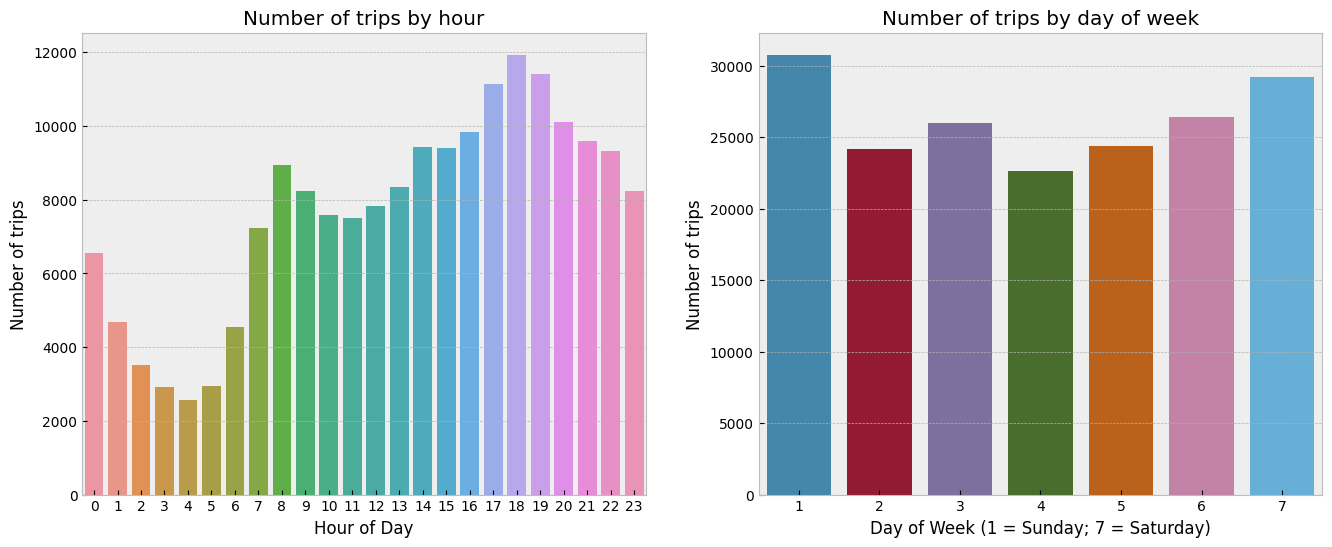

In [ ]:
# create subplot figure of size 1x2
plt.style.use('bmh')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# bar chart for hour of day

sns.countplot(ax = axes[0], x= trips_df_merged["hour_of_day"])
axes[0].set_title('Number of trips by hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of trips')

# bar chart for day of week

sns.countplot(ax = axes[1], x= trips_df_merged["day_of_week"])
axes[1].set_title('Number of trips by day of week')
axes[1].set_xlabel('Day of Week (1 = Sunday; 7 = Saturday)')
axes[1].set_ylabel('Number of trips')

# show figure
plt.show()

---
##Histograms

We visualize the distribution of the follow variables: **perc_tip** (non-zero), **before_tip_fare, perc_fee, trip_miles, trip_time, wait_time**

**Analysis**: TO-DO

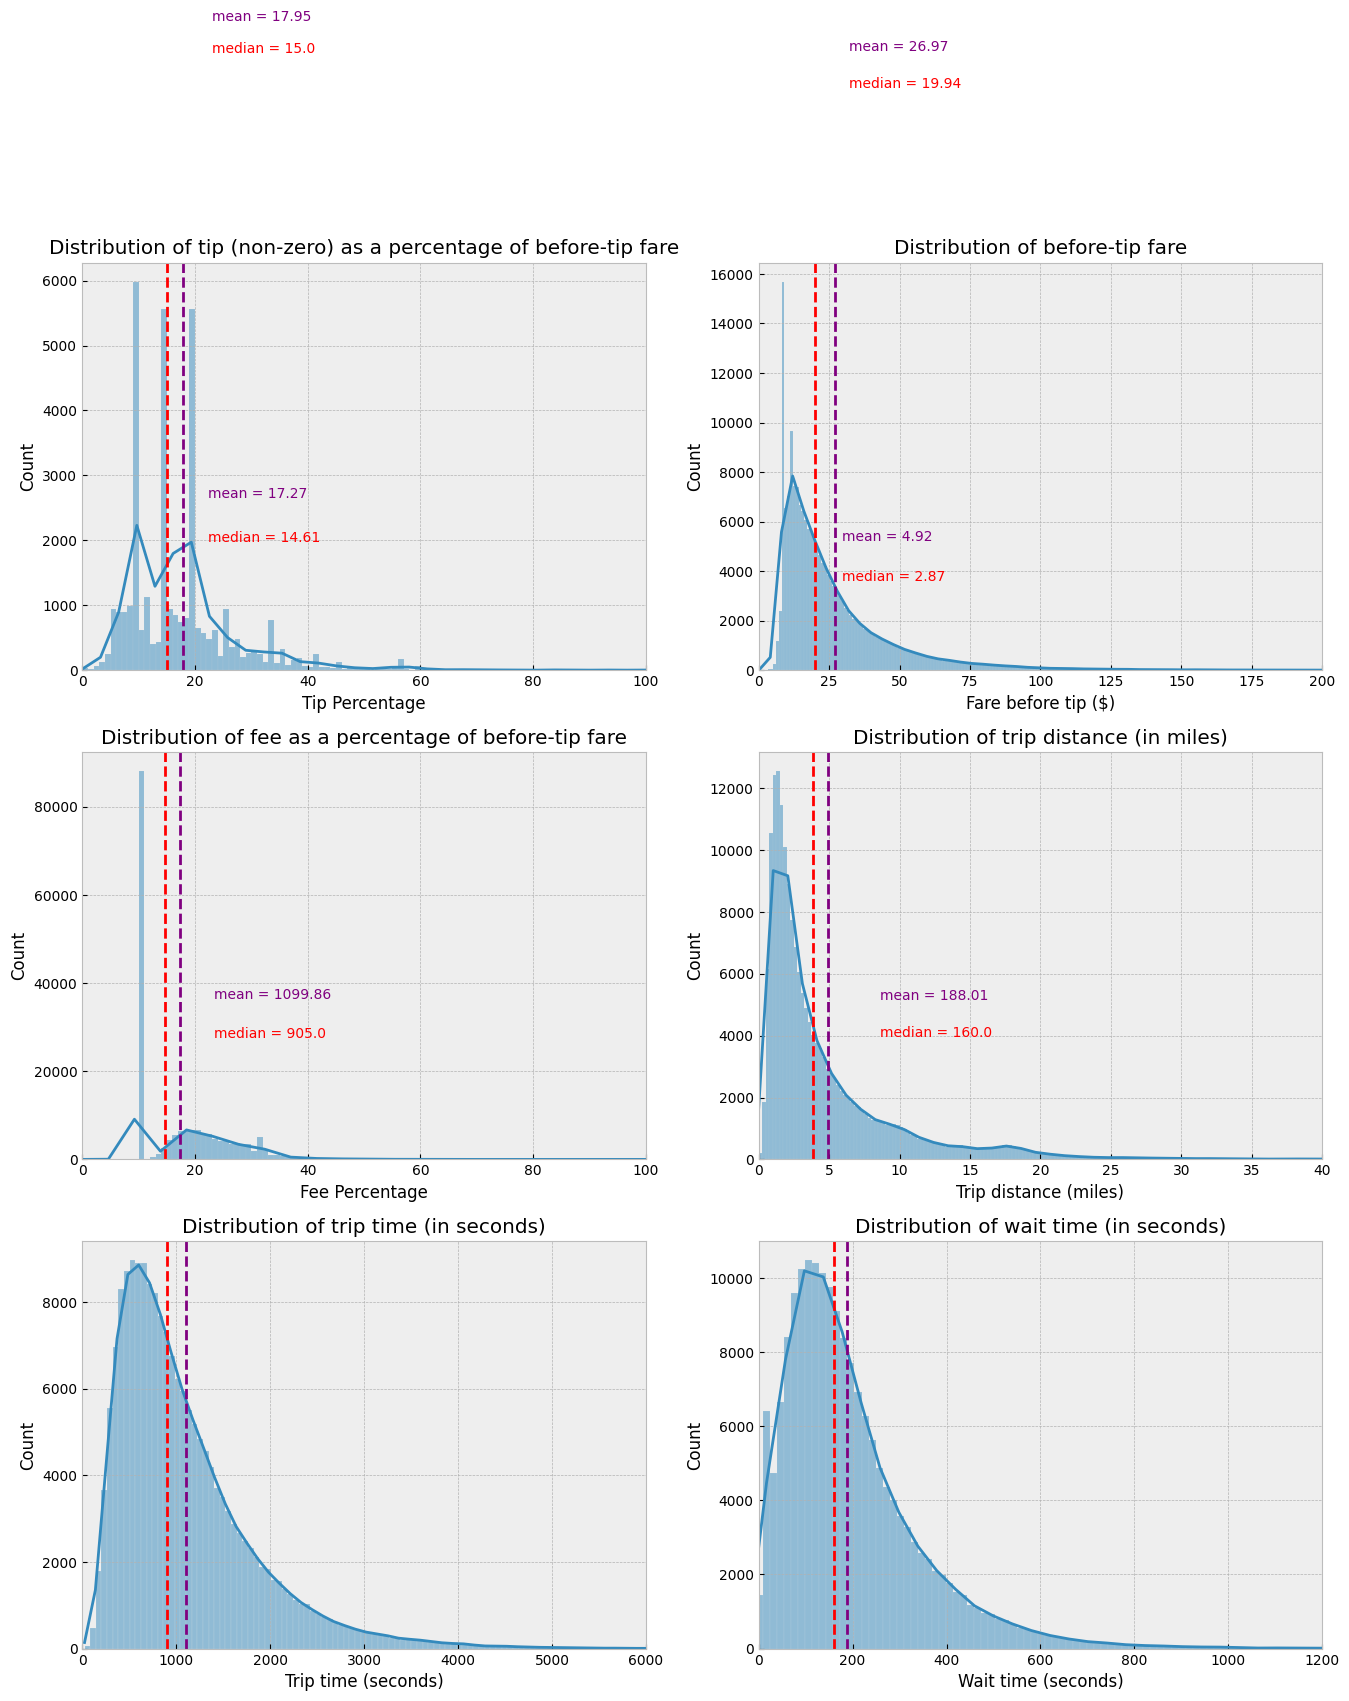

In [ ]:
# create subplot figure of size 3x2
plt.style.use('bmh')
fig, axes = plt.subplots(3,2, figsize=(16, 18))

# histogram for percentage tip (non-zero)

sns.histplot(ax = axes[0,0], data=nonzero_trips_df_merged, x= "perc_tip", binwidth=1, kde=True)
axes[0,0].set_xlim(0,100)
axes[0,0].set_title('Distribution of tip (non-zero) as a percentage of before-tip fare')
axes[0,0].set_xlabel('Tip Percentage')
axes[0,0].set_ylabel('Count')
mean1 = round(trips_df_merged[trips_df_merged['perc_tip'] != 0.0]['perc_tip'].mean(),2)
axes[0,0].axvline(mean1, color = 'purple', linestyle = '--')
axes[0,0].text(mean1 + 5, 10000, 'mean = ' + str(mean1), color = 'purple')
med1 = round(trips_df_merged[trips_df_merged['perc_tip'] != 0.0]['perc_tip'].median(),2)
axes[0,0].axvline(med1, color = 'red', linestyle = '--')
axes[0,0].text(mean1 + 5, 9500, 'median = ' + str(med1), color = 'red')

# histogram for fare before tip

sns.histplot(ax = axes[0,1], data=trips_df_merged, x= "before_tip_fare", binwidth=1, kde=True)
axes[0,1].set_xlim(0,200)
axes[0,1].set_title('Distribution of before-tip fare')
axes[0,1].set_xlabel('Fare before tip ($)')
axes[0,1].set_ylabel('Count')
mean2 = round(trips_df_merged['before_tip_fare'].mean(),2)
axes[0,1].axvline(mean2, color = 'purple', linestyle = '--')
axes[0,1].text(mean2 + 5, 25000, 'mean = ' + str(mean2), color = 'purple')
med2 = round(trips_df_merged['before_tip_fare'].median(),2)
axes[0,1].axvline(med2, color = 'red', linestyle = '--')
axes[0,1].text(mean2 + 5, 23500, 'median = ' + str(med2), color = 'red')

# histogram for percentage fee

sns.histplot(ax = axes[1,0], data=trips_df_merged, x= "perc_fee", binwidth=1, kde=True)
axes[1,0].set_xlim(0,100)
axes[1,0].set_title('Distribution of fee as a percentage of before-tip fare')
axes[1,0].set_xlabel('Fee Percentage')
axes[1,0].set_ylabel('Count')
mean3 = round(trips_df_merged['perc_fee'].mean(),2)
axes[1,0].axvline(mean3, color = 'purple', linestyle = '--')
axes[1,0].text(mean3 + 5, 150000, 'mean = ' + str(mean3), color = 'purple')
med3 = round(trips_df_merged['perc_fee'].median(),2)
axes[1,0].axvline(med3, color = 'red', linestyle = '--')
axes[1,0].text(mean3 + 5, 140000, 'median = ' + str(med3), color = 'red')

# histogram for trip distances

sns.histplot(ax = axes[1,1], data=trips_df_merged, x= "trip_miles", binwidth=0.25, kde=True)
axes[1,1].set_xlim(0,40)
axes[1,1].set_title('Distribution of trip distance (in miles)')
axes[1,1].set_xlabel('Trip distance (miles)')
axes[1,1].set_ylabel('Count')
mean4 = round(trips_df_merged['trip_miles'].mean(),2)
axes[1,1].axvline(mean4, color = 'purple', linestyle = '--')
axes[1,1].text(mean4 + 1, 20000, 'mean = ' + str(mean4), color = 'purple')
med4 = round(trips_df_merged['trip_miles'].median(),2)
axes[1,1].axvline(med4 + 1, color = 'red', linestyle = '--')
axes[1,1].text(mean4 + 1, 18700, 'median = ' + str(med4), color = 'red')

# histogram for trip time

sns.histplot(ax = axes[2,0], data=trips_df_merged, x= "trip_time", binwidth=60, kde=True)
axes[2,0].set_xlim(0,6000)
axes[2,0].set_title('Distribution of trip time (in seconds)')
axes[2,0].set_xlabel('Trip time (seconds)')
axes[2,0].set_ylabel('Count')
mean5 = round(trips_df_merged['trip_time'].mean(),2)
axes[2,0].axvline(mean5, color = 'purple', linestyle = '--')
axes[2,0].text(mean5 + 300, 15000, 'mean = ' + str(mean5), color = 'purple')
med5 = round(trips_df_merged['trip_time'].median(),2)
axes[2,0].axvline(med5, color = 'red', linestyle = '--')
axes[2,0].text(mean5 + 300, 14100, 'median = ' + str(med5), color = 'red')

# histogram for wait time

sns.histplot(ax = axes[2,1], data=trips_df_merged, x= "wait_time", binwidth=15, kde=True)
axes[2,1].set_xlim(0,1200)
axes[2,1].set_title('Distribution of wait time (in seconds)')
axes[2,1].set_xlabel('Wait time (seconds)')
axes[2,1].set_ylabel('Count')
mean6 = round(trips_df_merged['wait_time'].mean(),2)
axes[2,1].axvline(mean6, color = 'purple', linestyle = '--')
axes[2,1].text(mean6 + 70, 17500, 'mean = ' + str(mean6), color = 'purple')
med6 = round(trips_df_merged['wait_time'].median(),2)
axes[2,1].axvline(med6, color = 'red', linestyle = '--')
axes[2,1].text(mean6 + 70, 16500, 'median = ' + str(med6), color = 'red')

# show figure
plt.show()

---
##Overall Time Series Plots

In order to perform even more EDA to understand our variables, we create time series plots to visualize (1) the number of rides per day, (2) the average tip per day (averaged over all and non-zero), and (3) the average fare before tip per day for January 2023

**Analysis**:

Time Series Plots are very useful in visualizing trends over time. These plots are perfect for our data because our dataframe is for the whole month of January, meaning if we see patterns or trends from these plots, then we can identify specific variables we should look at later on in the analysis. Based on these time series plots, we can make the following observations:
* **number of trips per day**: Looking at the time series plot for this variable, we noticed that there were certain peaks that occurred every few days. When looking deeper into those days, we can see those days were Saturday, meaning in the month of January, people took Uber more on that day then any other day. Every other day had a significant drop off in the number of trips taken. Again, unsurprisingly, Monday is the day of the week in January with the least amount of trips.
* **Average tip per day**: Looking at this variable, there seems does not seem to be a certain pattern or trend that we can recognize. However, we do see the max peak landing on January 16, which is Martin Luther King Day. Perhaps this holiday leads people to tip more.
* **Average tip per day (non-zero tips)**: Looking at this variable, there seems to be no specific pattern or trends to figure out from this time series plot. The peaks of the average tip is not every other week, but are random number of days.
* **Average fare before tip per day**: Demonstrates high fare in early Janurary, most likely due to less supply of Uber drivers during the New Year Season, and then it normalizes to lower average fares.

Overall, the EDA using time series plot just further reinforces our hypotheses on days of the week affecting number of trips and potentially trips. From this analysis, maybe the day falling on a holilday can also play a role in predicting tip.



In [ ]:
# Create pandas dataframe with key variables grouped by day

trips_sdf_merged.createOrReplaceTempView("trips")

query = '''
        SELECT
          DAY(date) AS day,
          COUNT(company) AS count,
          AVG(perc_tip) AS avg_tip_all,
          AVG(NULLIF(perc_tip, 0)) AS avg_tip_nonzero,
          AVG(before_tip_fare) AS avg_before_tip
        FROM trips
        GROUP BY date
        ORDER BY date
        '''

overall_plot_df = spark.sql(query).toPandas()
overall_plot_df.head(5)

,day,count,avg_tip_all,avg_tip_nonzero,avg_before_tip
0,1,6105,2.792669,17.558437,35.299251
1,2,3848,3.398891,17.485205,28.054272
2,3,4599,3.629440,17.441790,27.730339
3,4,4909,3.658898,18.309410,28.146156
4,5,5070,3.674686,17.493576,27.531039


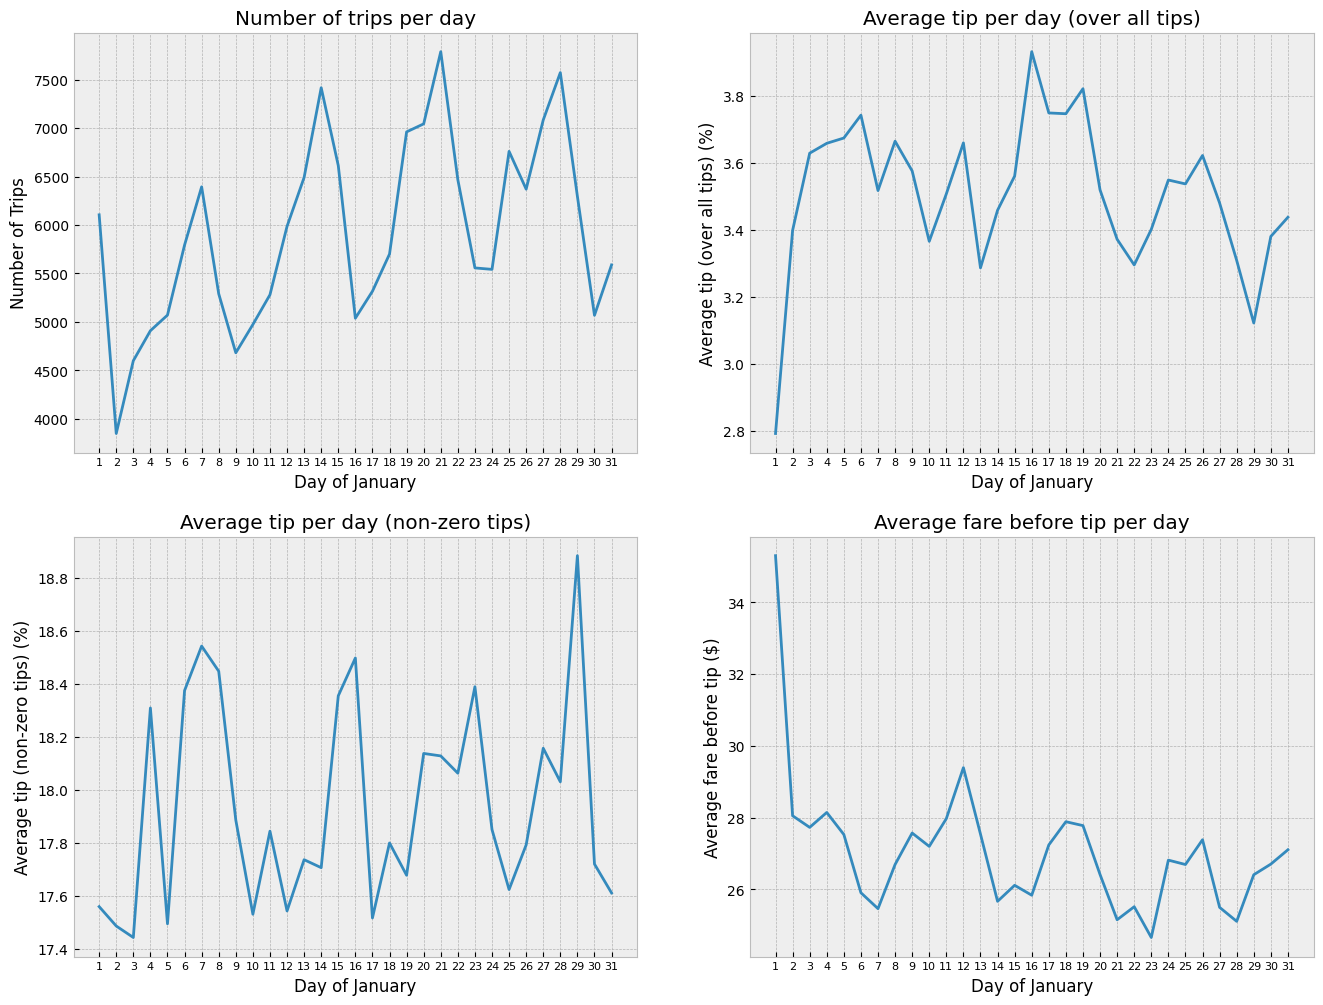

In [ ]:
# create subplot figure of size 2x2
plt.style.use('bmh')
fig, axes = plt.subplots(2,2, figsize=(16, 12))

# Number of trips per day

sns.lineplot(ax = axes[0,0], data=overall_plot_df, x = 'day', y = 'count')
axes[0,0].set_xticks(range(1,32))
axes[0,0].tick_params(axis='x', which='major', labelsize=8)
axes[0,0].set_title('Number of trips per day')
axes[0,0].set_xlabel('Day of January')
axes[0,0].set_ylabel('Number of Trips')

# Average tip per day (all tips)

sns.lineplot(ax = axes[0,1], data=overall_plot_df, x = 'day', y = 'avg_tip_all')
axes[0,1].set_xticks(range(1,32))
axes[0,1].tick_params(axis='x', which='major', labelsize=8)
axes[0,1].set_title('Average tip per day (over all tips)')
axes[0,1].set_xlabel('Day of January')
axes[0,1].set_ylabel('Average tip (over all tips) (%)')

# Average tip per day (non-zero tips)

sns.lineplot(ax = axes[1,0], data=overall_plot_df, x = 'day', y = 'avg_tip_nonzero')
axes[1,0].set_xticks(range(1,32))
axes[1,0].tick_params(axis='x', which='major', labelsize=8)
axes[1,0].set_title('Average tip per day (non-zero tips)')
axes[1,0].set_xlabel('Day of January')
axes[1,0].set_ylabel('Average tip (non-zero tips) (%)')

# Average fare before tip per day

sns.lineplot(ax = axes[1,1], data=overall_plot_df, x = 'day', y = 'avg_before_tip')
axes[1,1].set_xticks(range(1,32))
axes[1,1].tick_params(axis='x', which='major', labelsize=8)
axes[1,1].set_title('Average fare before tip per day')
axes[1,1].set_xlabel('Day of January')
axes[1,1].set_ylabel('Average fare before tip ($)')

# Show figure
plt.show()

---
##Heatmaps

We create heatmaps to visualize the concentration of pick-up and drop-off locations by TLC zones.

**Analysis**: The most concentrated regions for both pick-up and drop-off are the taxi zones associated with JFK and LaGuardia Airports. Other than those, there are a good number of trips originating and ending in lower Manhattan and throughout Brooklyn and Queens. Given that airport trips appear to be a significant part of the data set, we wonder if airports might be a predictor of tip. As such, we add an indicator for airports to our dataset (done above).

In [ ]:
# Import libraries needed to generate geographical heatmaps

!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 51.1 MB/s eta 0:00:00


In [ ]:
# Import shapefiles for taxi zones

s3.Bucket('cis5450project93').download_file('taxi_zones.dbf', 'taxi_zones.dbf')
s3.Bucket('cis5450project93').download_file('taxi_zones.prj', 'taxi_zones.prj')
s3.Bucket('cis5450project93').download_file('taxi_zones.sbn', 'taxi_zones.sbn')
s3.Bucket('cis5450project93').download_file('taxi_zones.sbx', 'taxi_zones.sbx')
s3.Bucket('cis5450project93').download_file('taxi_zones.shp', 'taxi_zones.shp')
s3.Bucket('cis5450project93').download_file('taxi_zones.shp.xml', 'taxi_zones.shp.xml')
s3.Bucket('cis5450project93').download_file('taxi_zones.shx', 'taxi_zones.shx')

In [ ]:
# Create a Pandas df to hold the number of rides per taxi zone and merge with shape file map

trips_locations = trips_sdf_clean.toPandas()[['PULocationID','DOLocationID']]
trips_locations_PU = trips_locations.groupby(by = 'PULocationID').size().reset_index(name='count')
trips_locations_DO = trips_locations.groupby(by = 'DOLocationID').size().reset_index(name='count')

zone_map = gpd.read_file("taxi_zones.shp")

map_and_locations_PU = zone_map.merge(trips_locations_PU, left_on="LocationID", right_on = 'PULocationID')
map_and_locations_DO = zone_map.merge(trips_locations_DO, left_on="LocationID", right_on = 'DOLocationID')

<ipython-input-34-57d612e838f1>:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

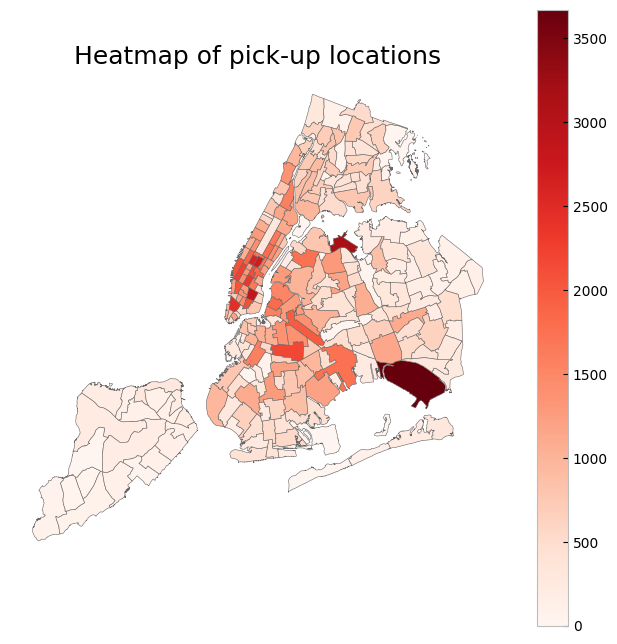

In [ ]:
# Create heat map using plt for pick up

fig, ax = plt.subplots(1, figsize=(8, 8))

map_and_locations_PU.plot(column="count", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max(trips_locations_PU['count'])))
bar_info._A = []
cbar = fig.colorbar(bar_info)

plt.title('Heatmap of pick-up locations', fontsize = 18)
plt.axis('off')

<ipython-input-35-a5225d3dbb7e>:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


(905464.7390389859, 1075092.878374982, 112485.76061678902, 280480.4146430247)

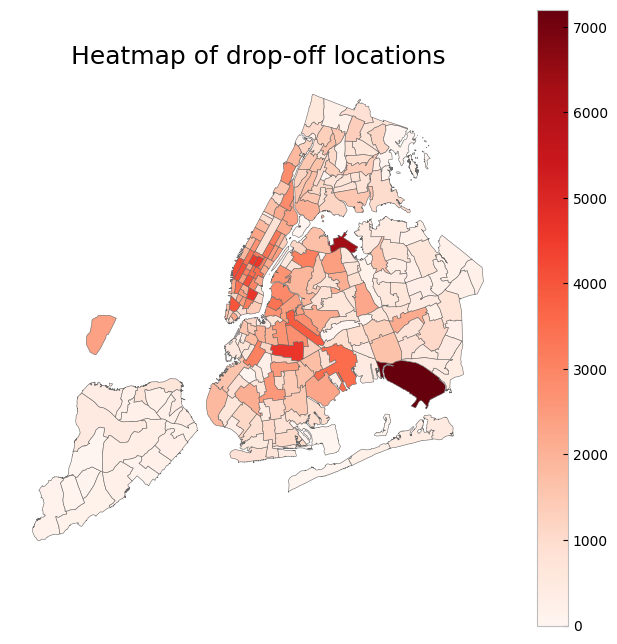

In [ ]:
# Create heat map using plt for drop off

fig, ax = plt.subplots(1, figsize=(8, 8))
plt.xticks(rotation=90)

map_and_locations_DO.plot(column="count", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")

bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max(trips_locations_DO['count'])))
bar_info._A = []
cbar = fig.colorbar(bar_info)

plt.title('Heatmap of drop-off locations', fontsize = 18)
plt.axis('off')

---
##Correlation Matrix

Finally, we visualize a correlation matrix to discern any pair-wise correlations to aid in our EDA.

**Analysis:**

Looking at both of our correlation matrices, we can see that there are certain features that display strong correlation, such as the "weather" data that we merged in the earlier step (temp_max, temp_min, temp_avg). Our implementation of PCA will lump all of these features together into one component.
* Interestingly, looking at the correlation matrix of the non-zero tip dataset, we can see that **perc_tip** does have some correlation to some of the features in the dataset, specifically, **trip_miles** and **trip_time**. This could be an indication that the longer a trip goes, the more costly the trip becomes, which results in the rider becoming less willing to give tip.

Run the correlation matrix for original data

<ipython-input-36-c6f6a0fcf321>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = trips_df_merged.corr()


<Axes: >

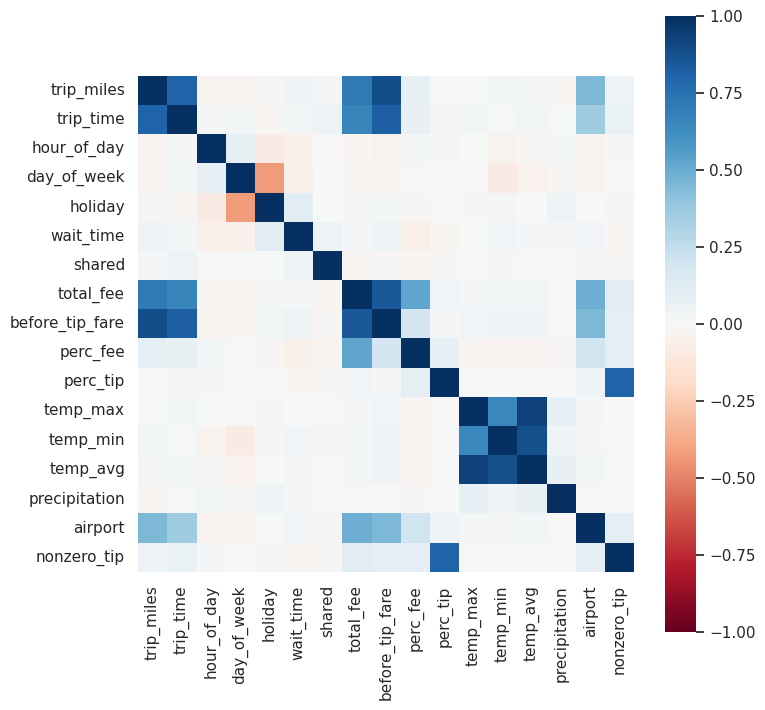

In [ ]:
from pyspark.ml.stat import Correlation

sns.set(rc={"figure.figsize":(8, 8)})
corr_mat = trips_df_merged.corr()
sns.heatmap(corr_mat, vmin = -1, vmax = 1, cmap = 'RdBu',square='True')

Run correlation matrix for the dataset with non_zero tips

<ipython-input-37-b88e91c8b718>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat_nonzero = nonzero_trips_df_merged.corr()


<Axes: >

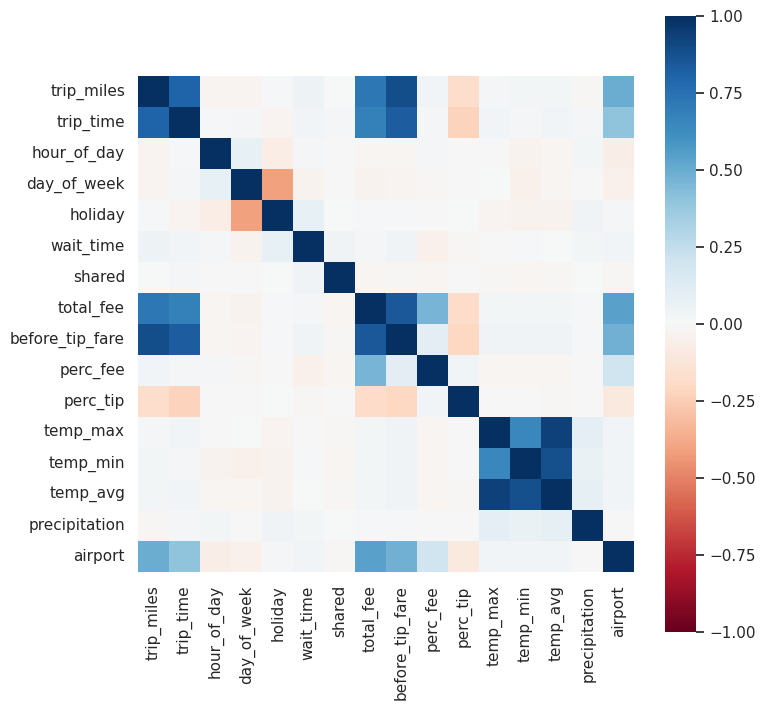

In [ ]:
sns.set(rc={"figure.figsize":(8, 8)})
corr_mat_nonzero = nonzero_trips_df_merged.corr()
sns.heatmap(corr_mat_nonzero, vmin = -1, vmax = 1, cmap = 'RdBu',square='True')

# IV. Setting Up Machine Learning

Now that we cleaned all the data to our liking and performed EDA on most of the variables, we now move on to setting up the datasets to run machine learning. In this section, we use Apache Spark ML to create training and testing datasets for our dataset

Apache Spark ML does not take in strings as inputs, so we begin by preprocessing strings into integers.

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

PU_Borough_indexer = StringIndexer(inputCol="PU_Borough", outputCol="PU_BoroughIndex")
PU_Zone_indexer = StringIndexer(inputCol="PU_Zone", outputCol="PU_ZoneIndex")
DO_Borough_indexer = StringIndexer(inputCol="DO_Borough", outputCol="DO_BoroughIndex")
DO_Zone_indexer = StringIndexer(inputCol="DO_Zone", outputCol="DO_ZoneIndex")

pipe  = Pipeline(stages = [PU_Borough_indexer,
                 PU_Zone_indexer, DO_Borough_indexer, DO_Zone_indexer])

trips_sdf_processed = pipe.fit(trips_sdf_merged).transform(trips_sdf_merged)
nonzero_trips_sdf_processed = pipe.fit(nonzero_trips_sdf_merged).transform(nonzero_trips_sdf_merged)

Then, we create columns using the processed data, then create a list called **feature_columns** to only contain the features we want to use for the ML model.

In [ ]:
# Store all column name in a list
all_columns = trips_sdf_processed.columns
drop_col = ['perc_tip', 'nonzero_tip', 'date', 'company', 'PU_Borough', 'PU_Zone', 'DO_Borough', 'DO_Zone']
feature_columns = [x for x in all_columns if x not in drop_col]

For Spark ML, we need to create a feature column which has all features concatenated as a list, and a single column for labels. We will use VectorAssembler() to create a feature vector from all our features, and we will call this vectorized variable as “features”. We also create a pipeline with a single stage — the assembler. Using this, we then transform our datasets.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

num_features = len(feature_columns)

# Create VectorAssembler object
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")

# Define a pipeline object
pipe  = Pipeline(stages = [assembler])

# Fit and transform the pipeline on the data and store the transformed sdf as "processed_reservations_sdf"
trips_sdf_processed = pipe.fit(trips_sdf_processed).transform(trips_sdf_processed)
nonzero_trips_sdf_processed = pipe.fit(nonzero_trips_sdf_processed).transform(nonzero_trips_sdf_processed)

Finally we have the data in the desired format, so we can now create the train and test datasets for the ML models. We will conduct an 80% training dataset and a 20% testing dataset.

In [ ]:
train_sdf, test_sdf = trips_sdf_processed.randomSplit([0.8, 0.2], seed = 121)
nonzero_train_sdf, nonzero_test_sdf = nonzero_trips_sdf_processed.randomSplit([0.8, 0.2], seed=677)

In [ ]:

'''
# TODO REMOVE THIS CELL -- this is for checking that we removed nulls
from functools import reduce
from operator import or_
from pyspark.sql.functions import col

# Get a list of all column names
columns = trips_sdf_processed.columns

# Create a list of null-checking conditions for each column
null_checks = [col(column).isNull() for column in columns]

# nan_checks = [col(column).isNaN() for column in columns]

# Combine the conditions using the reduce() and or_() functions
condition = reduce(or_, null_checks)

# Filter the rows containing null or NaN values in any column
null_rows = trips_sdf_processed.filter(condition)

# Show the resulting DataFrame
null_rows.show()
null_rows.count()
'''

'\n# TODO REMOVE THIS CELL -- this is for checking that we removed nulls\nfrom functools import reduce\nfrom operator import or_\nfrom pyspark.sql.functions import col\n\n# Get a list of all column names\ncolumns = trips_sdf_processed.columns\n\n# Create a list of null-checking conditions for each column\nnull_checks = [col(column).isNull() for column in columns]\n\n# nan_checks = [col(column).isNaN() for column in columns]\n\n# Combine the conditions using the reduce() and or_() functions\ncondition = reduce(or_, null_checks)\n\n# Filter the rows containing null or NaN values in any column\nnull_rows = trips_sdf_processed.filter(condition)\n\n# Show the resulting DataFrame\nnull_rows.show()\nnull_rows.count()\n'

# V. Training Models

In this section, we train different models and compare their accuracy

For each model, we will:
* Implement the model
* Calculate mean-squared prediction error
* Plot: predictions vs actual values together with a 45 degree (y=x) line

Then we will ultimately compare with model is the best.


##Regression (All Data, including No-Tips)

First, before we dive into the dataset that only has non_zero tips, we want to see if there would be accurate models for a variety of regression models using all of the data.

---
###Model 1 (base): Vanilla Linear Regression

Vanilla Linear Regression is beneficial in many ways. It allows us to easily assess the linearity assumption. By using the vanilla linear regression, we can see if this assumption is valid, or if a more complex model is necessary. In addition to that, the vanilla linear regression serves as the baseline model for all of the future complex models that we will implement for the training and testing data set for all the data.

Using Spark ML we import the LinearRegression and then proceed to define and fit the model to the training set. Then make predictions on the testing data in order to calculate the mean squared error (MSE)

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define the model
lr = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10)

# Fit the model to the training data
lr_model = lr.fit(train_sdf)

# Make predictions on the testing data
lr_predictions_sdf = lr_model.transform(test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
lr_rmse = evaluator.evaluate(lr_predictions_sdf)
print('Mean squared error: ', lr_rmse)


Mean squared error:  8.809480827463656


For the Vanilla Linear Regression Model, the MSE is 8.809

Now, in order to evaluate the performance of this predictive model, we now plot our predicted values vs. our actual values

```
# This is formatted as code
```

.

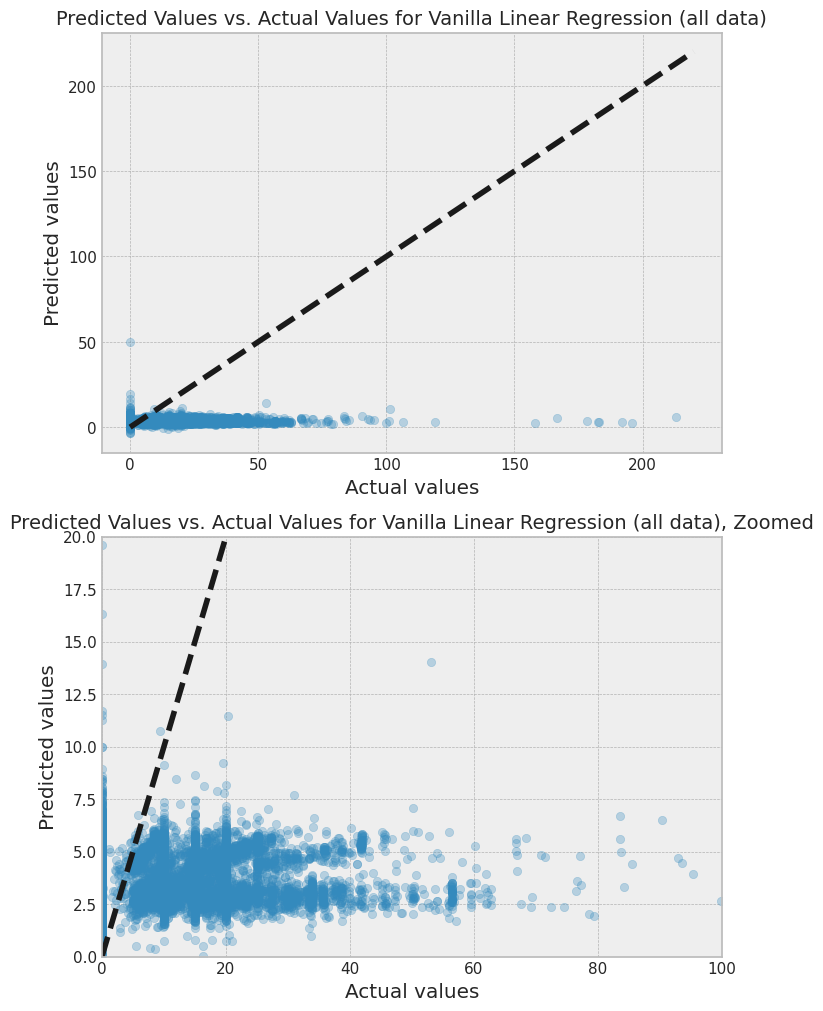

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (vanilla linear regression)
lr_y_true = np.array(lr_predictions_sdf.select('perc_tip').collect())
lr_y_pred = np.array(lr_predictions_sdf.select('prediction').collect())

axes[0].scatter(lr_y_true, lr_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Vanilla Linear Regression (all data)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(lr_y_true, lr_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 20])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Vanilla Linear Regression (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

**Analysis**

* At an initial glance, without even zooming into our scatterplot, we can see that there are a few outliers that are narrowing our view of the data, requiring us to zoom in to fully see whether the actual matches with the predicted values.
* Zooming into the scatterplot, we can see that the points are not close to the 45 degree line at all, meaning that the model is bad.

The model minimizes MSE, and because there are a lot of zeros in our dataset, it is only natural that the actual value does not pair up as well with the predicted value as it is going to predict close to zero. The zero tips drive down the prediction values.

We also can state that underfitting is occurring for these data points. This is characterized by high bias and low variance, which is what we have in our dataset with all data.

---
###Model 2: LASSO (L1) Regression

In [ ]:
# Define the model
lasso = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 1.0)

# Fit the model to the training data
lasso_model = lasso.fit(train_sdf)

# Make predictions on the testing data
lasso_predictions_sdf = lasso_model.transform(test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='mse')
lasso_mse = evaluator.evaluate(lasso_predictions_sdf)
print('Mean squared error: ', lasso_mse)

Mean squared error:  77.67381557156519


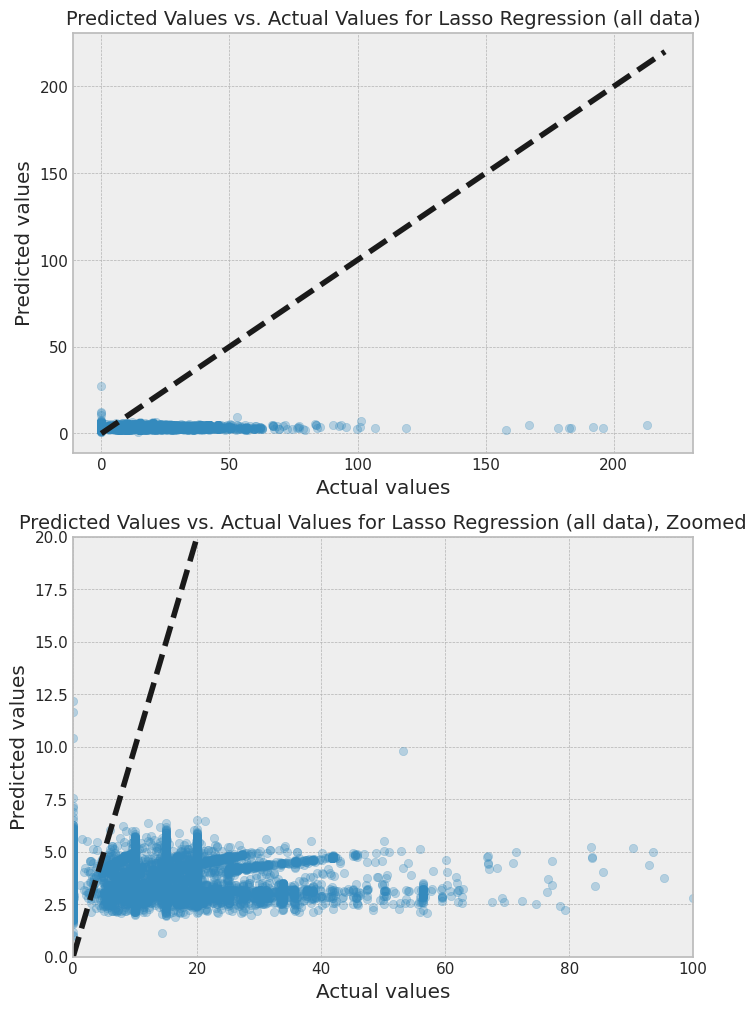

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (LASSO regression)
lasso_y_true = np.array(lasso_predictions_sdf.select('perc_tip').collect())
lasso_y_pred = np.array(lasso_predictions_sdf.select('prediction').collect())

axes[0].scatter(lasso_y_true, lasso_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Lasso Regression (all data)')
axes[0].title.set_size(14)

# zoomed in
axes[1].scatter(lasso_y_true, lasso_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 20])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Lasso Regression (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

---
###Model 3: Ridge (L2) Regression

In [ ]:
# Define the model
ridge = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 0)

# Fit the model to the training data
ridge_model = ridge.fit(train_sdf)

# Make predictions on the testing data
ridge_predictions_sdf = ridge_model.transform(test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
ridge_rmse = evaluator.evaluate(ridge_predictions_sdf)
print('Mean squared error: ', ridge_rmse)

Mean squared error:  8.805605008692936


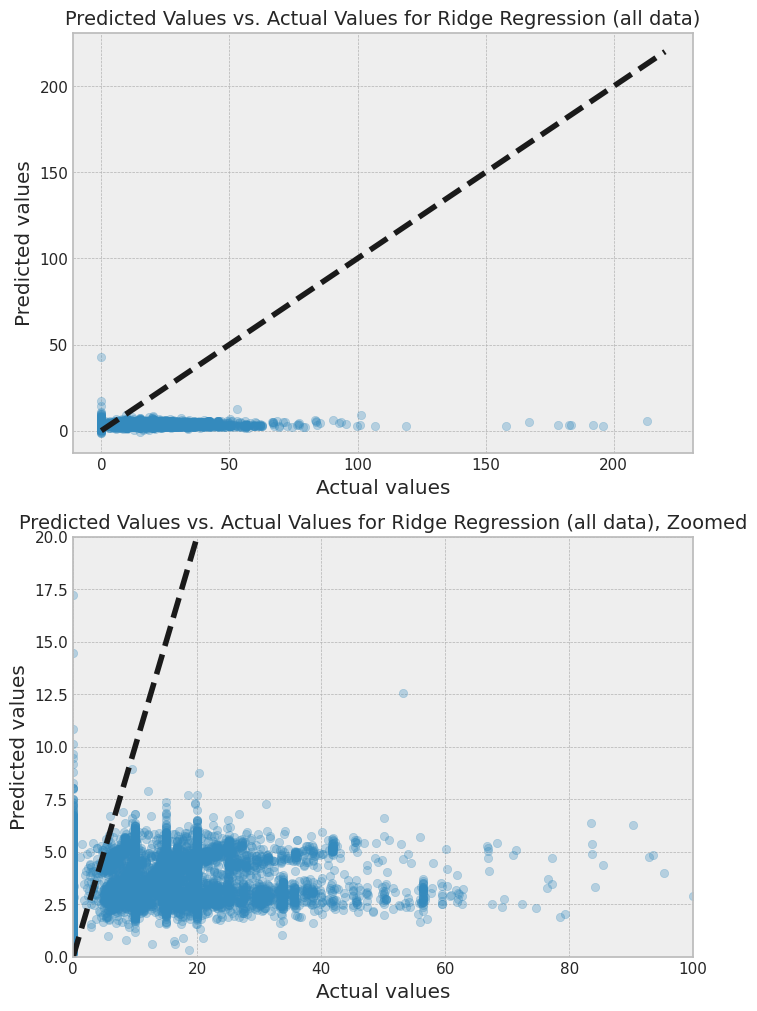

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (ridge regression)
ridge_y_true = np.array(ridge_predictions_sdf.select('perc_tip').collect())
ridge_y_pred = np.array(ridge_predictions_sdf.select('prediction').collect())

axes[0].scatter(ridge_y_true, ridge_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Ridge Regression (all data)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(ridge_y_true, ridge_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 20])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Ridge Regression (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

---
###Model 4: Elastic Net Regression

In [ ]:
# Define the model
en = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 0.5)

# Fit the model to the training data
en_model = en.fit(train_sdf)

# Make predictions on the testing data
en_predictions_sdf = en_model.transform(test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
en_rmse = evaluator.evaluate(en_predictions_sdf)
print('Mean squared error: ', en_rmse)

Mean squared error:  8.809593829901866


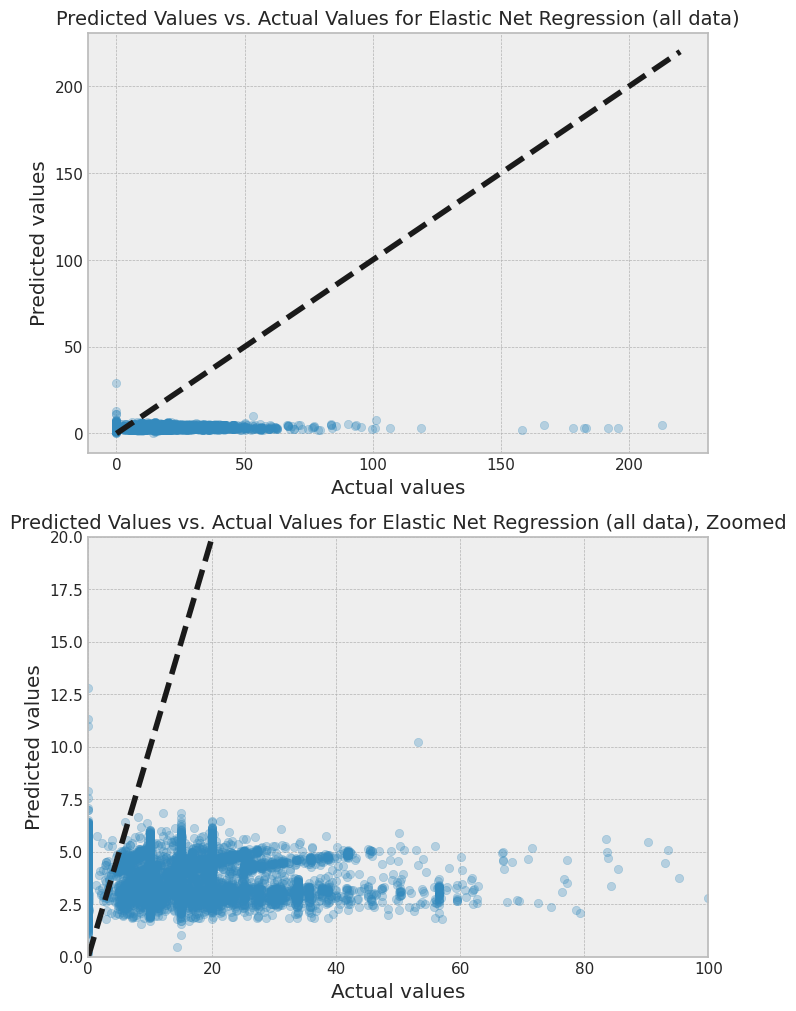

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (elastic net regression)
en_y_true = np.array(en_predictions_sdf.select('perc_tip').collect())
en_y_pred = np.array(en_predictions_sdf.select('prediction').collect())

axes[0].scatter(en_y_true, en_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Elastic Net Regression (all data)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(en_y_true, en_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 20])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Elastic Net Regression (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

---
###Model 5: PCA + Vanilla Linear Regression

As our correlation heatmap shows, there are several features that are correlated with each other (e.g., temp_max, temp_min, and temp_avg). PCA will help with reduce dimensionality and perhaps further minimize our error.

First, we create an explained variance plot to determine an ideal number of principal components to use.

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

# Perform feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)
scalerModel = scaler.fit(train_sdf)
scaled_train_sdf = scalerModel.transform(train_sdf)
scaled_test_sdf = scalerModel.transform(test_sdf)

# Instantiate PCA object, then fit and transform
pca = PCA(k = num_features, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_train_sdf)
pca_train_sdf = pca_model.transform(scaled_train_sdf)

In [ ]:
pca_model.explainedVariance

DenseVector([0.9357, 0.0531, 0.0073, 0.0033, 0.0003, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Explained Variance Ratio'),
 Text(0.5, 1.0, 'Cumulative explained variance ratio over number of components')]

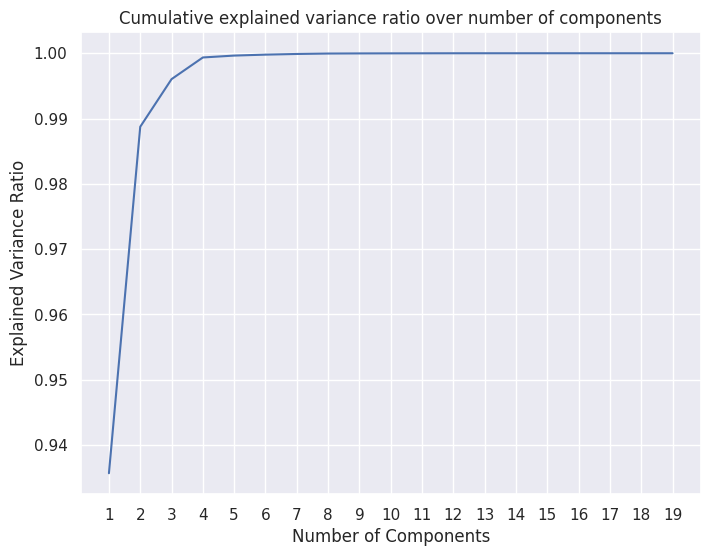

In [ ]:
cum_evr = pca_model.explainedVariance.cumsum()
sns.set(rc={"figure.figsize":(8, 6)})
g = sns.lineplot(x=range(1,len(cum_evr)+1), y=cum_evr)
g.set_xticks(range(1,len(cum_evr)+1))
g.set(xlabel = 'Number of Components',
      ylabel = 'Explained Variance Ratio',
      title = 'Cumulative explained variance ratio over number of components')

Next, we use PCA to perform dimensionality reduction. Based on our explained variance plot, 2 components seems to be enough to explain the vast majority of variation (0.9884) without capturing too much noise, so we choose 2 components.

In [ ]:
# Instantiate PCA object with 2 components
pca = PCA(k = 2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(scaled_train_sdf)
pca_train_sdf = pca_model.transform(scaled_train_sdf)
pca_test_sdf = pca_model.transform(scaled_test_sdf)

In [ ]:
# Define the model
pca_lr = LinearRegression(featuresCol='pcaFeatures', labelCol="perc_tip", maxIter = 10)

# Fit the model to the training data
pca_lr_model = pca_lr.fit(pca_train_sdf)

# Make predictions on the testing data
pca_lr_predictions_sdf = pca_lr_model.transform(pca_test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
pca_lr_rmse = evaluator.evaluate(pca_lr_predictions_sdf)
print('Mean squared error: ', pca_lr_rmse)

Mean squared error:  8.848916229362418


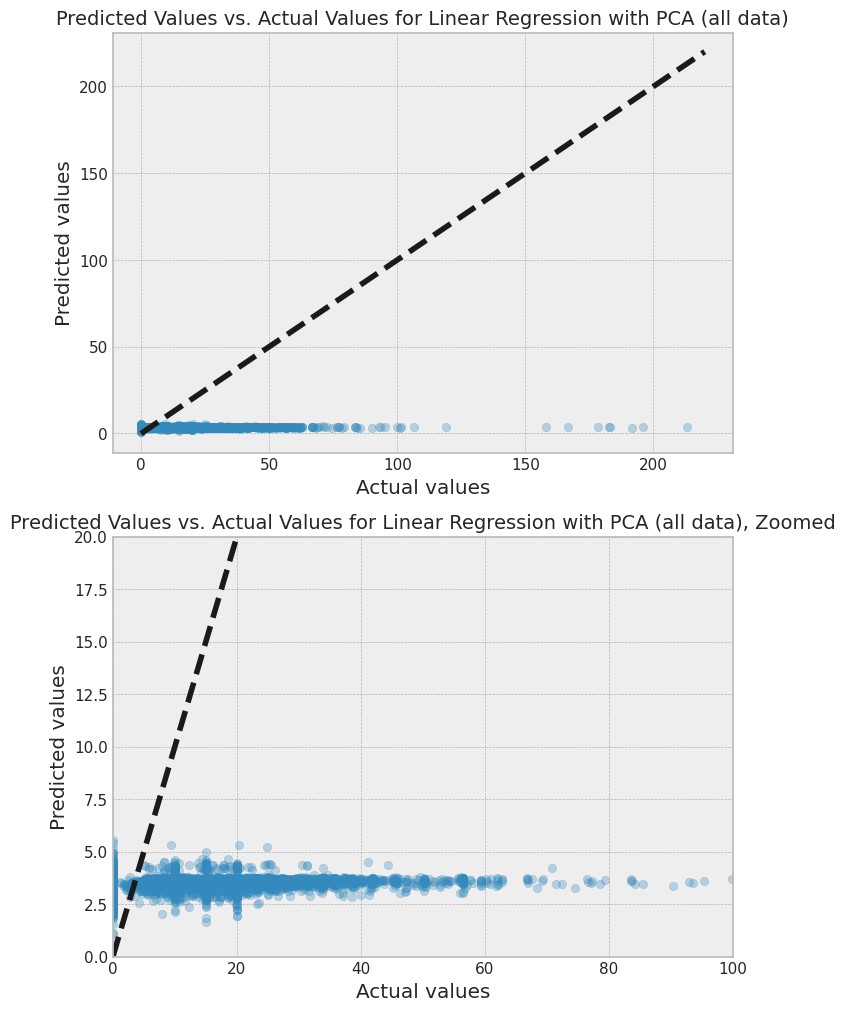

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (lin reg with pca)
pca_lr_y_true = np.array(pca_lr_predictions_sdf.select('perc_tip').collect())
pca_lr_pred = np.array(pca_lr_predictions_sdf.select('prediction').collect())

axes[0].scatter(pca_lr_y_true, pca_lr_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Linear Regression with PCA (all data)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(pca_lr_y_true, pca_lr_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 20])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Linear Regression with PCA (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

---
###Model 6: Random Forest

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(featuresCol = "features", labelCol = "perc_tip", maxDepth = 10, seed = 677, maxBins = 257)

# Fit the model to the training data
rf_model = rf.fit(train_sdf)

# Make predictions on the testing data
rf_predictions_sdf = rf_model.transform(test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
rf_rmse = evaluator.evaluate(rf_predictions_sdf)
print('Mean squared error: ', rf_rmse)

Mean squared error:  8.798695267534951


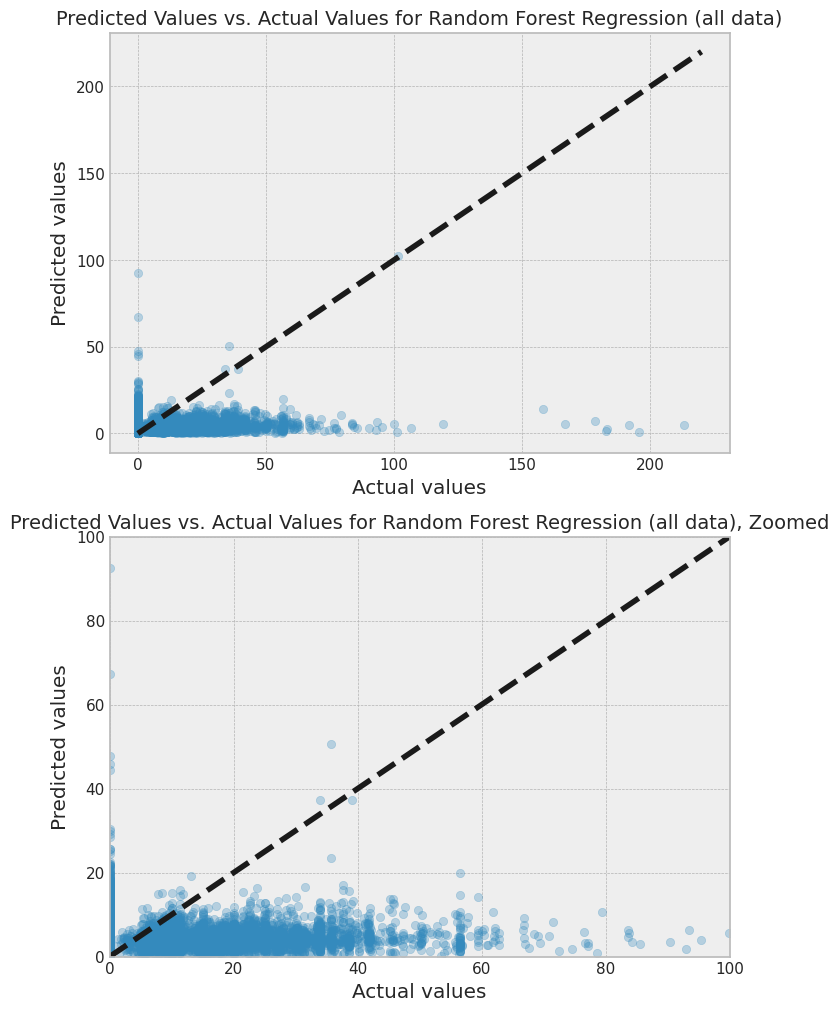

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (random forest regression)
rf_y_true = np.array(rf_predictions_sdf.select('perc_tip').collect())
rf_y_pred = np.array(rf_predictions_sdf.select('prediction').collect())

axes[0].scatter(rf_y_true, rf_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Random Forest Regression (all data)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(rf_y_true, rf_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 100])
axes[1].set_ylim([0, 100])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Random Forest Regression (all data), Zoomed')
axes[1].title.set_size(14)

plt.show()

---
###Model 7 (?) Some deep learning model with pytorch?

##Regression with Nonzero Tips Only

###Model 1 (base): Vanilla Linear Regression

In [ ]:
# Define the model
nonzero_lr = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10)

# Fit the model to the training data
nonzero_lr_model = nonzero_lr.fit(nonzero_train_sdf)

# Make predictions on the testing data
nonzero_lr_predictions_sdf = nonzero_lr_model.transform(nonzero_test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
nonzero_lr_rmse = evaluator.evaluate(nonzero_lr_predictions_sdf)
print('Mean squared error: ', nonzero_lr_rmse)

Mean squared error:  11.073551115430366


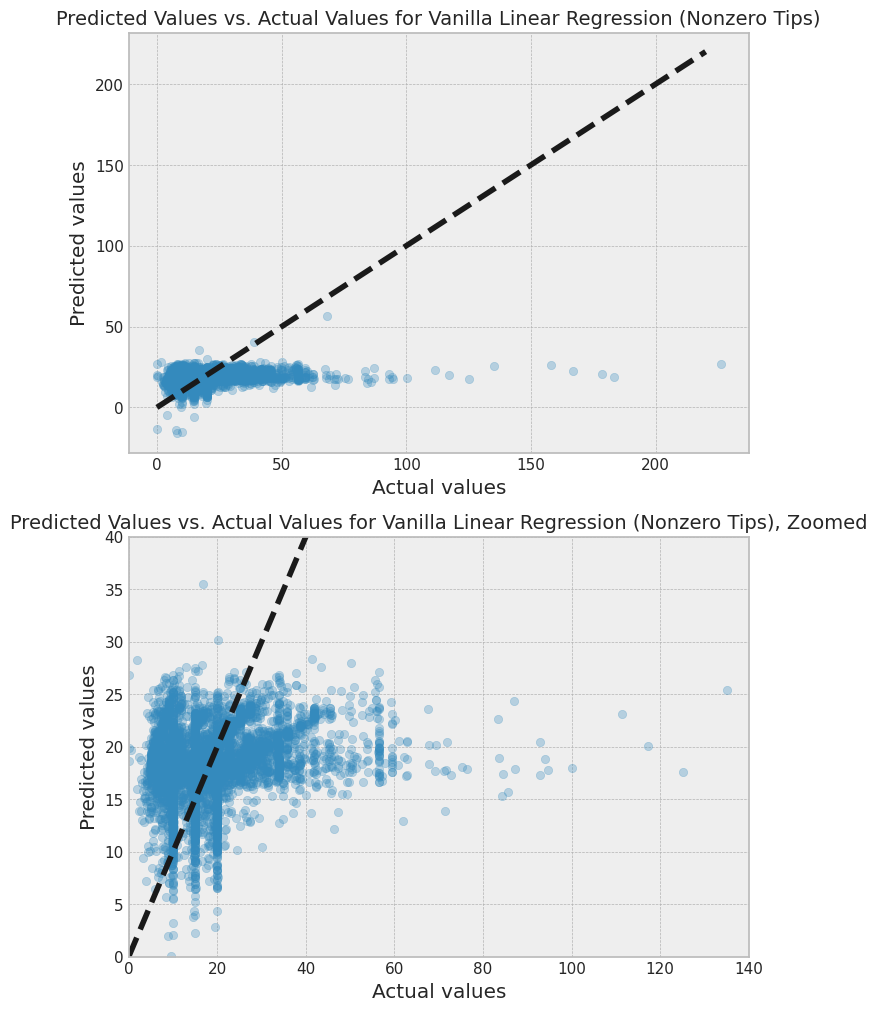

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (vanilla linear regression)
nonzero_lr_y_true = np.array(nonzero_lr_predictions_sdf.select('perc_tip').collect())
nonzero_lr_y_pred = np.array(nonzero_lr_predictions_sdf.select('prediction').collect())

axes[0].scatter(nonzero_lr_y_true, nonzero_lr_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Vanilla Linear Regression (Nonzero Tips)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(nonzero_lr_y_true, nonzero_lr_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 140])
axes[1].set_ylim([0, 40])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Vanilla Linear Regression (Nonzero Tips), Zoomed')
axes[1].title.set_size(14)

plt.show()

1. correlation heatmap
2. most of reason why first model was doing poorly because they are biased towards zero, and now that we got rid of that, the models are more fine tune.

###Model 2: LASSO (L1) Regression

In [ ]:
# Define the model
nonzero_lasso = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 1.0)

# Fit the model to the training data
nonzero_lasso_model = nonzero_lasso.fit(nonzero_train_sdf)

# Make predictions on the testing data
nonzero_lasso_predictions_sdf = nonzero_lasso_model.transform(nonzero_test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
nonzero_lasso_rmse = evaluator.evaluate(nonzero_lasso_predictions_sdf)
print('Mean squared error: ', nonzero_lasso_rmse)

Mean squared error:  11.007164463253835


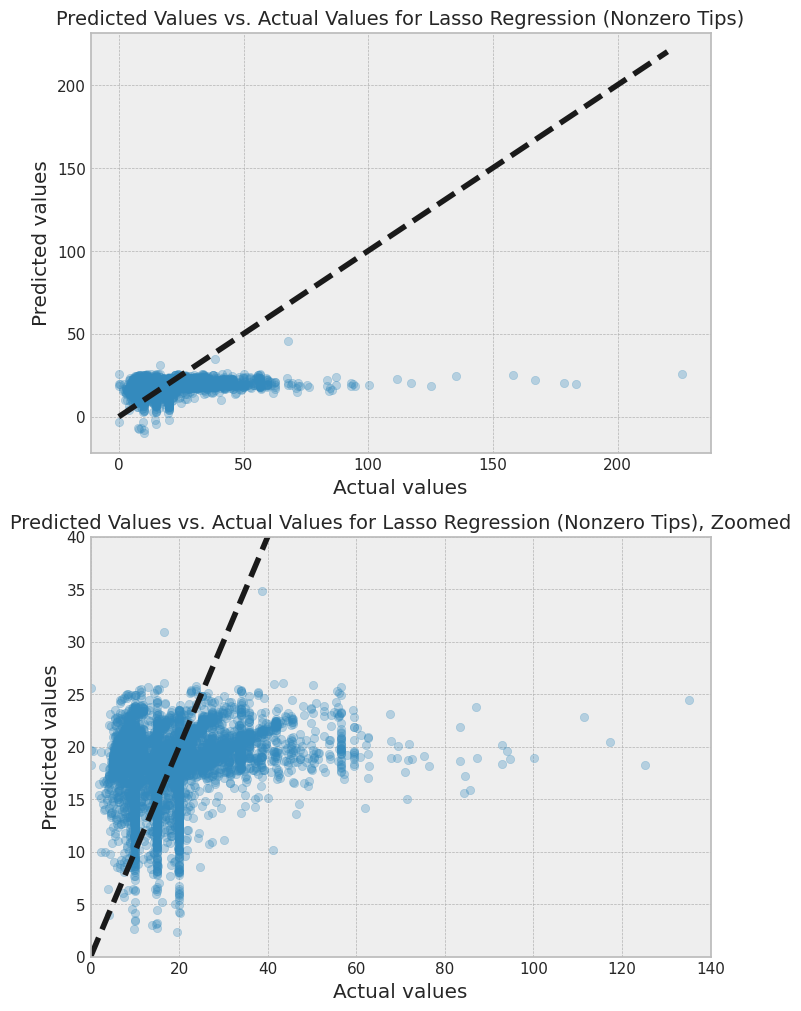

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (lasso regression)
nonzero_lasso_y_true = np.array(nonzero_lasso_predictions_sdf.select('perc_tip').collect())
nonzero_lasso_y_pred = np.array(nonzero_lasso_predictions_sdf.select('prediction').collect())

axes[0].scatter(nonzero_lasso_y_true, nonzero_lasso_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Lasso Regression (Nonzero Tips)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(nonzero_lasso_y_true, nonzero_lasso_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 140])
axes[1].set_ylim([0, 40])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Lasso Regression (Nonzero Tips), Zoomed')
axes[1].title.set_size(14)

plt.show()

###Model 3: Ridge (L2) Regression

In [ ]:
# Define the model
nonzero_ridge = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 0)

# Fit the model to the training data
nonzero_ridge_model = nonzero_ridge.fit(nonzero_train_sdf)

# Make predictions on the testing data
nonzero_ridge_predictions_sdf = nonzero_ridge_model.transform(nonzero_test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
nonzero_ridge_rmse = evaluator.evaluate(nonzero_ridge_predictions_sdf)
print('Mean squared error: ', nonzero_ridge_rmse)

Mean squared error:  11.044047977847226


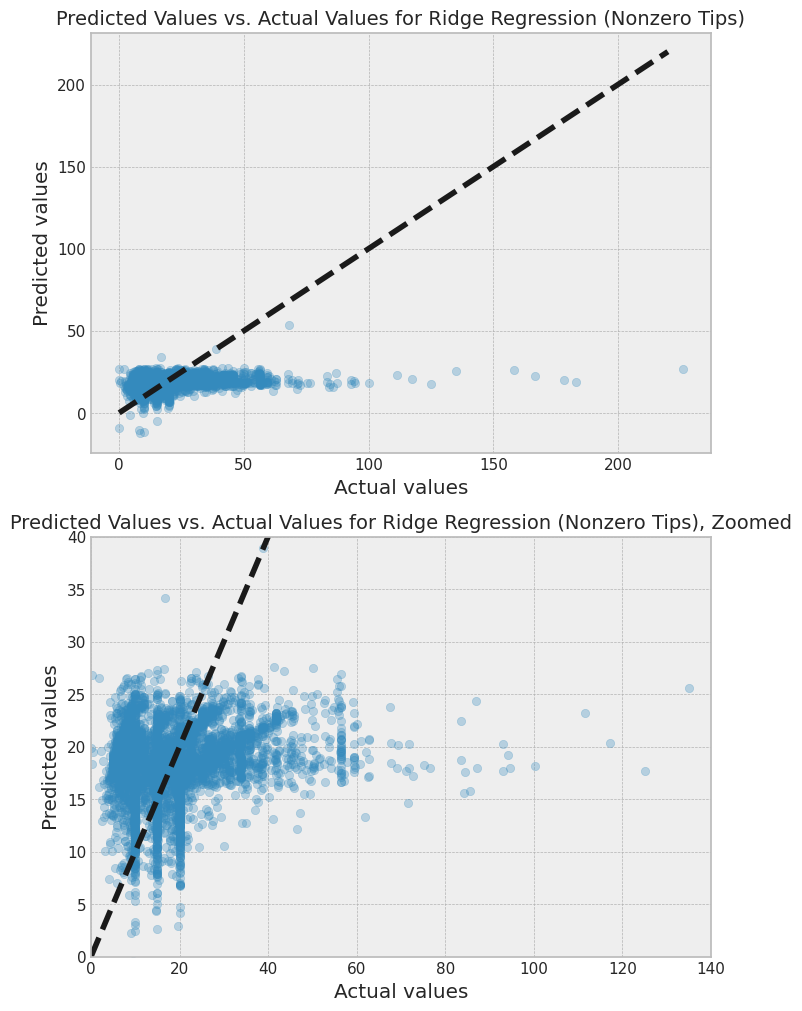

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (Ridge regression)
nonzero_ridge_y_true = np.array(nonzero_ridge_predictions_sdf.select('perc_tip').collect())
nonzero_ridge_y_pred = np.array(nonzero_ridge_predictions_sdf.select('prediction').collect())

axes[0].scatter(nonzero_ridge_y_true, nonzero_ridge_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Ridge Regression (Nonzero Tips)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(nonzero_ridge_y_true, nonzero_ridge_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 140])
axes[1].set_ylim([0, 40])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Ridge Regression (Nonzero Tips), Zoomed')
axes[1].title.set_size(14)

plt.show()

###Model 4: Elastic Net Regression

In [ ]:
# Define the model
nonzero_en = LinearRegression(featuresCol='features', labelCol="perc_tip", maxIter = 10, regParam = 0.1, elasticNetParam = 0.5)

# Fit the model to the training data
nonzero_en_model = nonzero_en.fit(nonzero_train_sdf)

# Make predictions on the testing data
nonzero_en_predictions_sdf = nonzero_en_model.transform(nonzero_test_sdf)

# Calculate the mean squared error
evaluator = RegressionEvaluator(labelCol="perc_tip", predictionCol='prediction', metricName='rmse')
nonzero_en_rmse = evaluator.evaluate(nonzero_en_predictions_sdf)
print('Mean squared error: ', nonzero_en_rmse)

Mean squared error:  11.020980920104869


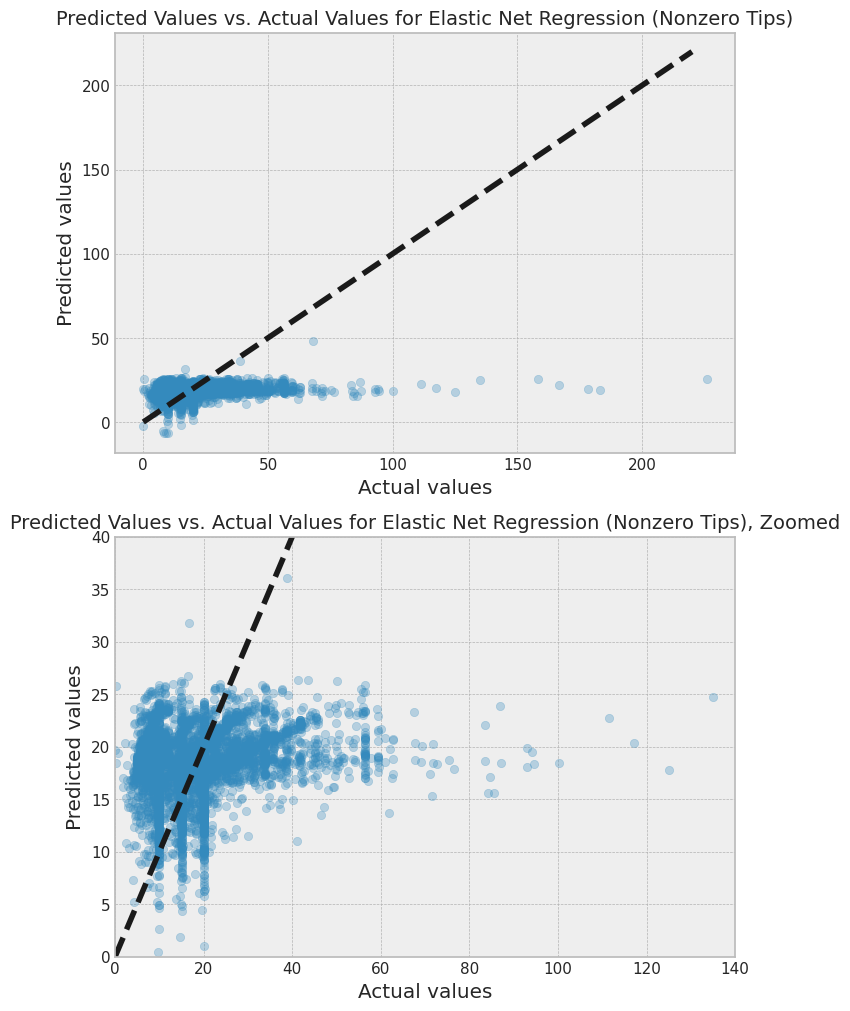

In [ ]:
plt.style.use('bmh')
fig, axes = plt.subplots(2,1, figsize=(8, 12))

# Plot the predicted values against the actual values (Elastic Net regression)
nonzero_en_y_true = np.array(nonzero_en_predictions_sdf.select('perc_tip').collect())
nonzero_en_y_pred = np.array(nonzero_en_predictions_sdf.select('prediction').collect())

axes[0].scatter(nonzero_en_y_true, nonzero_en_y_pred, alpha=0.3)
axes[0].plot([0, 220], [0, 220], 'k--', lw=4)
axes[0].set_xlabel('Actual values')
axes[0].set_ylabel('Predicted values')
axes[0].set_title('Predicted Values vs. Actual Values for Elastic Net Regression (Nonzero Tips)')
axes[0].title.set_size(14)

# Zoomed in
axes[1].scatter(nonzero_en_y_true, nonzero_en_y_pred, alpha=0.3)
axes[1].plot([0, 100], [0, 100], 'k--', lw=4)
axes[1].set_xlim([0, 140])
axes[1].set_ylim([0, 40])
axes[1].set_xlabel('Actual values')
axes[1].set_ylabel('Predicted values')
axes[1].set_title('Predicted Values vs. Actual Values for Elastic Net Regression (Nonzero Tips), Zoomed')
axes[1].title.set_size(14)

plt.show()

##Binary Classification (Tip or No-Tip)

###Model 1 (base): Vanilla Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Instantiate model
logreg = LogisticRegression(featuresCol = "features", labelCol = "nonzero_tip", maxIter = 10)

# Fit and Transform
logreg_model = logreg.fit(train_sdf)
logreg_pred = logreg_model.transform(test_sdf)
logreg_pred = logreg_pred.withColumn('nonzero_tip', col('nonzero_tip').cast(DoubleType()))

NameError: ignored

In [ ]:
logreg_pred.show(10)

We now create the confusion matrix for the above classifier.

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

labels_and_predictions = logreg_pred['nonzero_tip', 'prediction']

# Instantiate metrics objects
metrics = MulticlassMetrics(labels_and_predictions.rdd)

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

In [ ]:
logreg_test_accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
logreg_test_accuracy

###Model 2: LASSO (L1) Regression

In [ ]:
# Instantiate model
lasso = LogisticRegression(featuresCol = "features", labelCol = "nonzero_tip", elasticNetParam=1.0, maxIter = 10, regParam = 0.1)

# Fit and Transform
lasso_model = lasso.fit(train_sdf)
lasso_pred = lasso_model.transform(test_sdf)
lasso_pred = lasso_pred.withColumn('nonzero_tip', col('nonzero_tip').cast(DoubleType()))

In [ ]:
# TODO REMOVE
lasso_pred.show(20)

In [ ]:
labels_and_predictions = lasso_pred['nonzero_tip', 'prediction']

# TO-DO: Instantiate metrics objects
metrics = MulticlassMetrics(labels_and_predictions.rdd)

# TO-DO: Create confusion matrix and store it as a numpy array named "confusion_matrix"
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix

In [ ]:
lasso_test_accuracy = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
lasso_test_accuracy

### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize model
rf = RandomForestClassifier(featuresCol = "features", labelCol = "nonzero_tip", maxDepth = 10, maxBins = 257)

# Fit model
rf_model = rf.fit(train_sdf)

# Get predictions
rf_predictions_sdf = rf_model.transform(test_sdf)
rf_predictions_sdf = rf_predictions_sdf.withColumn('nonzero_tip', col('nonzero_tip').cast(DoubleType()))
rf_predictions_sdf.show(20)

In [ ]:
labels_and_predictions = rf_predictions_sdf['nonzero_tip', 'prediction']

# TO-DO: Instantiate metrics objects
metrics = MulticlassMetrics(labels_and_predictions.rdd)

# TO-DO: Create confusion matrix and store it as a numpy array named "confusion_matrix"
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix